In [21]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import japanize_matplotlib
import statsmodels.api as sm
%matplotlib inline
# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

In [22]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df['year'] = train_df['date']//10000
test_df['year'] = test_df['date']//10000
train_df['month'] = train_df['date'].apply(lambda x: int(str(x)[4:6]))
test_df['month'] = test_df['date'].apply(lambda x: int(str(x)[4:6]))

kinds = test_df['kind'].unique()
train_df = train_df[train_df['kind'].isin(kinds)]

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)
all_df.drop('weekno', axis=1, inplace=True)
all_df = all_df.query('20170101 <= date').reset_index(drop=True)
vis_df = pd.pivot_table(all_df, index=['year', 'month'], columns='kind', values='mode_price').reset_index()
temp = vis_df.copy()
temp.loc[:, temp.columns[2:]] = np.NaN
temp = pd.DataFrame(temp.iloc[-1]).T
temp['month'] = 11
vis_df = pd.concat([vis_df, temp]).reset_index(drop=True)
vis_df.index = [str(int(year)) + str(month) + '1' for year, month in zip(vis_df['year'], vis_df['month'])]
vis_df.index = pd.to_datetime(vis_df.index, format='%Y%m%d')
vis_df

kind,year,month,かぼちゃ,きゅうり,さといも,たまねぎ,だいこん,なましいたけ,にんじん,ねぎ,はくさい,ほうれんそう,キャベツ,トマト,ピーマン,ミニトマト,レタス
2017-01-01,2017.0,1,NaN,1981.800000,2357.775000,1779.300000,820.800000,220.800000,1927.800000,1787.400000,1410.750000,96.725000,1123.200000,1490.400000,106.400000,167.962500,2338.200000
2017-02-01,2017.0,2,NaN,1566.000000,2929.500000,1633.500000,899.100000,213.800000,1900.800000,1900.800000,1377.000000,84.350000,1393.200000,1420.200000,116.400000,158.675000,2214.000000
2017-03-01,2017.0,3,3418.434783,1432.173913,2981.739130,2014.434783,990.782609,178.478261,1805.478261,1995.652174,1913.478261,82.065217,1324.173913,1281.913043,84.739130,142.630435,1826.608696
2017-04-01,2017.0,4,2838.857143,1404.000000,NaN,2296.285714,1002.857143,173.000000,1807.714286,1854.000000,2005.714286,98.571429,1260.000000,1265.142857,76.880952,133.309524,1738.285714
2017-05-01,2017.0,5,2042.181818,1129.090909,NaN,2182.090909,918.000000,173.000000,1495.636364,1826.181818,1156.090909,81.363636,898.545455,1026.000000,67.784091,112.318182,1286.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,2022.0,7,2304.818182,1482.545455,NaN,4566.409091,1381.909091,NaN,1806.545455,1769.727273,976.909091,118.409091,819.818182,1276.363636,80.568182,139.000000,794.045455
2022-08-01,2022.0,8,1918.285714,1512.000000,NaN,4842.000000,1314.000000,NaN,1415.571429,2088.000000,982.285714,163.666667,740.571429,1604.571429,82.261905,156.261905,956.571429
2022-09-01,2022.0,9,1692.000000,1522.285714,3595.764706,4757.142857,1388.571429,117.904762,1900.285714,1931.142857,1380.857143,139.380952,866.571429,1959.428571,71.547619,193.904762,1548.000000
2022-10-01,2022.0,10,1448.181818,1909.636364,3244.909091,4015.636364,999.000000,118.454545,1602.818182,1674.000000,1143.818182,116.159091,697.090909,2194.363636,67.306818,187.636364,1693.636364


In [23]:
data = vis_df.copy()

# # データをトレンドと季節成分に分解
# seasonal_decompose_res = sm.tsa.seasonal_decompose(data[kind], freq=12)
# seasonal_decompose_res.plot()

# diff = data[kind].diff()
# diff = diff.dropna()

In [24]:
kind = 'かぼちゃ'

train_data = data[data.index < "2022-10"]
# テストデータはテスト期間以前の日付も含まなければいけない
test_data = data[data.index >= "2022-01"]

# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p = 3
max_q = 3
max_d = 2
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_d + 1)*(max_q + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])

# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            train_data[kind], order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.loc[num]["model"] = str(p) + "_" + str(d) + "_"+ str(q) + "," + str(sp) + "_" + str(sd) + "_" + str(sq)
                        modelSelection.loc[num]["aic"] = sarima.aic
                        num = num + 1

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67734D+00    |proj g|=  1.77924D-01

At iterate    5    f=  6.67598D+00    |proj g|=  2.86203D-03

At iterate   10    f=  6.67589D+00    |proj g|=  4.45093D-02

At iterate   15    f=  6.67419D+00    |proj g|=  2.16453D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     22      1     0     0   2.875D-06   6.674D+00
  F =   6.6741617970492371     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates,


At iterate    5    f=  1.86827D+01    |proj g|=  3.22873D-02
  ys=-2.141E+01  -gs= 5.263E-01 BFGS update SKIPPED
  ys=-1.801E+01  -gs= 5.212E-01 BFGS update SKIPPED
  ys=-1.614E+01  -gs= 5.184E-01 BFGS update SKIPPED

At iterate   10    f=  1.04456D+01    |proj g|=  3.17629D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11    116      2     3     0   3.176D+04   1.045D+01
  F =   10.445608311121854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38501D+00    |proj g|=  2.72439D-01

At iterate    5    f=  5.33289D+00    |proj g|=  1.77523D-03

At iterate   10    f=  5.33285D+00    |proj g|=  6.99577D-03

At iterate   15    f=  5.32751D+00    |proj g|=  8.92261D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04305D+00    |proj g|=  1.80367D-01

At iterate    5    f=  5.33750D+00    |proj g|=  2.06737D-01

At iterate   10    f=  5.30800D+00    |proj g|=  8.65210D-04

At iterate   15    f=  5.30797D+00    |proj g|=  1.24083D-02

At iterate   20    f=  5.30527D+00    |proj g|=  1.40524D-01

At iterate   25    f=  5.27382D+00    |proj g|=  1.99481D-01

At iterate   30    f=  5.18418D+00    |proj g|=  8.47406D-02

At iterate   35    f=  5.18296D+00    |proj g|=  1.94628D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   6.958D-07   4.022D+00
  F =   4.0217860863562978     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03231D+01    |proj g|=  2.97587D-02


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.85633D+01    |proj g|=  3.25242D-02
  ys=-2.088E+01  -gs= 5.260E-01 BFGS update SKIPPED
  ys=-4.154E+02  -gs= 5.354E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     91      2     2     0   9.440D+04   1.004D+01
  F =   10.041047118832470     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65117D+00    |proj g|=  2.38327D-02

At iterate    5    f=  6.65063D+00    |proj g|=  1.35747D-04

At iterate   10    f=  6.65057D+00    |proj g|=  6.74896D-03

At iterate   15    f=  6.64856D+00    |proj g|=  1.02717D-01

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble


At iterate   10    f=  5.86333D+00    |proj g|=  1.47982D-03

At iterate   15    f=  5.86275D+00    |proj g|=  2.56690D-02

At iterate   20    f=  5.63526D+00    |proj g|=  1.21996D+00

At iterate   25    f=  5.60002D+00    |proj g|=  1.08650D-01

At iterate   30    f=  5.54721D+00    |proj g|=  3.83562D-02

At iterate   35    f=  5.51724D+00    |proj g|=  4.09461D-02

At iterate   40    f=  5.50227D+00    |proj g|=  1.03667D-01

At iterate   45    f=  5.49577D+00    |proj g|=  1.09498D-01

At iterate   50    f=  5.49036D+00    |proj g|=  3.49086D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     77   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates,


At iterate    5    f=  5.28623D+00    |proj g|=  7.30467D-04

At iterate   10    f=  5.28622D+00    |proj g|=  2.27871D-03

At iterate   15    f=  5.28586D+00    |proj g|=  2.78413D-02

At iterate   20    f=  5.27882D+00    |proj g|=  1.36933D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   2.935D-06   5.279D+00
  F =   5.2787090290208054     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  5.28287D+00    |proj g|=  1.04141D-01

At iterate   30    f=  5.27012D+00    |proj g|=  4.10825D-03

At iterate   35    f=  5.26979D+00    |proj g|=  2.84233D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     47      1     0     0   2.972D-06   5.270D+00
  F =   5.2697848491116428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03370D+00    |proj g|=  1.79991D-01



/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate    5    f=  5.60485D+00    |proj g|=  2.69604D+00

At iterate   10    f=  5.30627D+00    |proj g|=  2.02480D-02

At iterate   15    f=  5.30497D+00    |proj g|=  7.10242D-04

At iterate   20    f=  5.30493D+00    |proj g|=  1.27443D-02

At iterate   25    f=  5.30084D+00    |proj g|=  1.45983D-01

At iterate   30    f=  5.21493D+00    |proj g|=  3.40615D-01

At iterate   35    f=  5.18591D+00    |proj g|=  6.04598D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     49      1     0     0   3.228D-06   5.185D+00
  F =   5.1852669125227822     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  4.06610D+00    |proj g|=  4.31900D-02

At iterate   25    f=  4.02808D+00    |proj g|=  7.21642D-02

At iterate   30    f=  4.02575D+00    |proj g|=  5.99991D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     47      1     0     0   1.771D-06   4.026D+00
  F =   4.0257529469548308     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03304D+01    |proj g|=  3.19726D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.83051D+01    |proj g|=  2.89383D-01
  ys=-2.753E+01  -gs= 3.341E-01 BFGS update SKIPPED
  ys=-1.635E+01  -gs= 5.200E-01 BFGS update SKIPPED
  ys=-5.969E+00  -gs= 4.586E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15    109      2     3     0   2.355D+05   8.668D+00
  F =   8.6679735281845360     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50004D+00    |proj g|=  4.53215D-02

At iterate    5    f=  6.48617D+00    |proj g|=  1.05928D+00

At iterate   10    f=  6.45905D+00    |proj g|=  4.41930D-01

At iterate   15    f=  6.45885D+00    |proj g|=  2.52543D-03

       

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  5.70540D+00    |proj g|=  1.35499D-02

At iterate   25    f=  5.70520D+00    |proj g|=  7.58128D-02

At iterate   30    f=  5.68144D+00    |proj g|=  1.15157D+00

At iterate   35    f=  5.52171D+00    |proj g|=  5.28519D-01

At iterate   40    f=  5.49013D+00    |proj g|=  3.73758D-01

At iterate   45    f=  5.45284D+00    |proj g|=  2.31739D-01


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  5.41497D+00    |proj g|=  2.92482D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   2.925D-02   5.415D+00
  F =   5.4149652203295195     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17932D+00    |proj g|=  5.99592D-02

At iterate    5    f=  5.17631D+00    |proj g|=  4.88503D-03

At iterate   10    f=  5.17622D+00    |proj g|=  2.92984D-04

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98905D+01    |proj g|=  2.49019D-02

At iterate    5    f=  1.98851D+01    |proj g|=  2.43925D-03

At iterate   10    f=  1.98673D+01    |proj g|=  8.12365D-02
  ys=-3.609E+03  -gs= 5.307E-01 BFGS update SKIPPED

At iterate   15    f=  1.06118D+01    |proj g|=  4.02707D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     73      1     1     0   4.027D+03   1.061D+01
  F =   10.611818876465332     

CONVERGENCE: REL_


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.33823D+00    |proj g|=  1.18173D-02

At iterate   20    f=  5.29791D+00    |proj g|=  1.89648D-01

At iterate   25    f=  5.26887D+00    |proj g|=  1.52970D-02

At iterate   30    f=  5.26834D+00    |proj g|=  1.14985D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     38      1     0     0   2.513D-06   5.268D+00
  F =   5.2683432641086991     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91567D+00    |proj g|=  1.76115D-01

At iterate    5    f=  5.45129D+00    |proj g|=  5.38874D-01

At iterate   10    f=  5.19789D+00    |proj g|=  1.41865D-02

At iterate   15    f=  5.19772D+00    |proj g|=  7.97311D-04

At iterate   20    f=  5.19751D+00    |proj g|=  1.90691D-02

At iterate   25    f=  5.16992D+00    |proj g|=  3.49785D-01

At iterate   30    f=  5.11021D+00    |proj g|=  1.35109D-01

At iterate   35    f=  5.07661D+00    |proj g|=  2.40229D-01

At iterate   40    f=  5.06496D+00    |proj g|=  1.42519D-01

At iterate   45    f=  5.06021D+00    |proj g|=  6.47657D-03

At iterate   50    f=  5.06020D+00    |proj g|=  9.03236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13136D+00    |proj g|=  1.90507D-01

At iterate    5    f=  4.06830D+00    |proj g|=  1.69306D-02

At iterate   10    f=  4.06339D+00    |proj g|=  1.74982D-02

At iterate   15    f=  4.06305D+00    |proj g|=  4.74382D-04

At iterate   20    f=  4.06299D+00    |proj g|=  6.62622D-03

At iterate   25    f=  4.05555D+00    |proj g|=  8.40486D-02

At iterate   30    f=  3.99573D+00    |proj g|=  5.47369D-02

At iterate   35    f=  3.99279D+00    |proj g|=  5.20533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.97549D+01    |proj g|=  8.12353D-02
  ys=-1.945E+01  -gs= 5.154E-01 BFGS update SKIPPED

At iterate   15    f=  9.68429D+00    |proj g|=  1.14431D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     77      1     1     0   1.144D+05   9.684D+00
  F =   9.6842907777399319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36169D+00    |proj g|=  1.83523D+00

At iterate    5  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  6.31550D+00    |proj g|=  5.58480D-03

At iterate   15    f=  6.31548D+00    |proj g|=  6.91030D-02

At iterate   20    f=  6.31547D+00    |proj g|=  1.16798D-02

At iterate   25    f=  6.31547D+00    |proj g|=  2.02376D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   2.024D-04   6.315D+00
  F =   6.3154736893870007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.54978D+00    |proj g|=  5.04887D-01

At iterate   10    f=  5.54565D+00    |proj g|=  3.38543D-01

At iterate   15    f=  5.54514D+00    |proj g|=  1.54718D-02

At iterate   20    f=  5.54499D+00    |proj g|=  4.55703D-02

At iterate   25    f=  5.54495D+00    |proj g|=  1.19952D-03

At iterate   30    f=  5.54495D+00    |proj g|=  7.73612D-03

At iterate   35    f=  5.54495D+00    |proj g|=  4.26376D-04

At iterate   40    f=  5.54494D+00    |proj g|=  2.97001D-02

At iterate   45    f=  5.54399D+00    |proj g|=  2.24711D-02


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  5.45896D+00    |proj g|=  2.39166D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   2.392D+00   5.459D+00
  F =   5.4589636520822786     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12829D+00    |proj g|=  6.42258D-01

At iterate    5    f=  5.06307D+00    |proj g|=  2.55504D-01

At iterate   10    f=  5.05072D+00    |proj g|=  1.28298D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93516D+01    |proj g|=  3.89381D-01

At iterate    5    f=  1.92753D+01    |proj g|=  3.84094D-03

At iterate   10    f=  1.92744D+01    |proj g|=  1.09239D-02

At iterate   15    f=  1.92579D+01    |proj g|=  2.61894D-01

At iterate   20    f=  1.92267D+01    |proj g|=  2.34660D-01

At iterate   25    f=  1.92209D+01    |proj g|=  7.30206D-01

At iterate   30    f=  1.92206D+01    |proj g|=  5.83083D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.30606D+00    |proj g|=  1.47941D-01

At iterate   15    f=  5.30531D+00    |proj g|=  1.33329D-03

At iterate   20    f=  5.30530D+00    |proj g|=  1.46305D-03

At iterate   25    f=  5.30530D+00    |proj g|=  5.53977D-03

At iterate   30    f=  5.30521D+00    |proj g|=  3.60900D-02

At iterate   35    f=  5.30466D+00    |proj g|=  9.06828D-02

At iterate   40    f=  5.27883D+00    |proj g|=  6.83382D-02

At iterate   45    f=  5.26534D+00    |proj g|=  5.34623D-02

At iterate   50    f=  5.25505D+00    |proj g|=  1.47104D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.29863D+00    |proj g|=  8.38692D-01

At iterate   10    f=  5.06251D+00    |proj g|=  1.23766D-01

At iterate   15    f=  5.04753D+00    |proj g|=  9.38976D-02

At iterate   20    f=  5.04457D+00    |proj g|=  1.16244D-02

At iterate   25    f=  5.04447D+00    |proj g|=  1.69526D-03

At iterate   30    f=  5.04446D+00    |proj g|=  3.50439D-03

At iterate   35    f=  5.04415D+00    |proj g|=  4.75494D-02

At iterate   40    f=  5.03179D+00    |proj g|=  2.71869D-01

At iterate   45    f=  4.95761D+00    |proj g|=  6.33299D-02

At iterate   50    f=  4.93399D+00    |proj g|=  2.47574D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21294D+00    |proj g|=  6.42548D-01

At iterate    5    f=  4.03382D+00    |proj g|=  1.74498D-02

At iterate   10    f=  4.03294D+00    |proj g|=  2.12534D-02

At iterate   15    f=  4.03264D+00    |proj g|=  5.75050D-03

At iterate   20    f=  4.03261D+00    |proj g|=  4.26696D-04

At iterate   25    f=  4.03253D+00    |proj g|=  9.51371D-03

At iterate   30    f=  4.02464D+00    |proj g|=  1.00892D-01

At iterate   35    f=  3.99094D+00    |proj g|=  1.21248D-02

At iterate   40    f=  3.99068D+00    |proj g|=  3.54323D-04

At iterate   45    f=  3.99068D+00    |proj g|=  3.95803D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Ca

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.91660D+01    |proj g|=  3.84094D-03

At iterate   10    f=  1.91651D+01    |proj g|=  1.09239D-02

At iterate   15    f=  1.91486D+01    |proj g|=  2.47614D-01

At iterate   20    f=  1.91130D+01    |proj g|=  1.71042D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency in


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     57      1     0     0   1.208D+00   1.911D+01
  F =   19.111475630732066     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66235D+00    |proj g|=  1.42522D-02

At iterate    5    f=  6.66222D+00    |proj g|=  1.44240D-03

At iterate   10    f=  6.66210D+00    |proj g|=  5.87029D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

At iterate    5    f=  2.16282D+01    |proj g|=  1.05899D-02
  ys=-3.978E+01  -gs= 3.108E-01 BFGS update SKIPPED

At iterate   10    f=  1.69964D+01    |proj g|=  7.58519D+00
  ys=-4.448E+01  -gs= 5.299E-01 BFGS update SKIPPED
  ys=-4.370E+00  -gs= 4.700E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14    102      2     3     0   1.597D+05   1.062D+01
  F =   10.619377710813954     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49492D+00    |proj g|=  4.74505D-01

At iterate    5    f=  5.33141D+00    |proj g|=  3.76079D-04

At iterate   10    f=  5.33033D+00    |proj g|=  2.85889D-02

At iterate   15    f=  5.30475D+00    |proj g|=  9.15484D-02

At iter

 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41256D+00    |proj g|=  2.45215D-01

At iterate    5    f=  5.31441D+00    |proj g|=  7.49526D-02

At iterate   10    f=  5.31221D+00    |proj g|=  1.82879D-03

At iterate   15    f=  5.31017D+00    |proj g|=  5.29820D-02

At iterate   20    f=  5.25527D+00    |proj g|=  1.16355D-01

At iterate   25    f=  5.25064D+00    |proj g|=  1.47746D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.22272D+00    |proj g|=  2.39940D-01

At iterate    5    f=  4.17464D+00    |proj g|=  6.33400D-05

At iterate   10    f=  4.17463D+00    |proj g|=  2.02234D-03

At iterate   15    f=  4.17426D+00    |proj g|=  1.31022D-02

At iterate   20    f=  4.17397D+00    |proj g|=  1.50373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     23      1     0     0   2.062D-06   4.174D+00
  F =   4.1739726489140034     

CONVERG

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15838D+01    |proj g|=  9.77554D-03

At iterate    5    f=  2.15825D+01    |proj g|=  1.05899D-02
  ys=-3.977E+01  -gs= 3.108E-01 BFGS update SKIPPED

At iterate   10    f=  1.68657D+01    |proj g|=  8.88833D+00
  ys=-2.039E+01  -gs= 5.228E-01 BFGS update SKIPPED
  ys=-1.383E+00  -gs= 3.402E-01 BFGS update SKIPPED
  ys=-2.599E-02  -gs= 3.863E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15    122      2     4     0   3.698D+05   8.499D+00
  F =   8.4991365799575505     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49378D+00    |proj g|=  1.23989D-01

At iterate    5    f=  6.43754D+00    |proj g|=  1.31632D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23065D+00    |proj g|=  4.98602D-02

At iterate    5    f=  5.19309D+00    |proj g|=  1.02505D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     18      1     0     0   9.729D-06   5.193D+00
  F =   5.1930716062908999     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v


 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22    112      2     2     0   6.686D+02   1.169D+01
  F =   11.685225751389359     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47693D+00    |proj g|=  4.40604D-01

At iterate    5    f=  5.31210D+00    |proj g|=  6.01951D-03

At iterate   10    f=  5.31208D+00    |proj g|=  1.31185D-03

At iterate   15    f=  5.31155D+00    |proj g|=  2.23909D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.27110D+00    |proj g|=  2.10377D-01

At iterate    5    f=  5.20005D+00    |proj g|=  8.26993D-02

At iterate   10    f=  5.17350D+00    |proj g|=  1.41156D-02

At iterate   15    f=  5.17283D+00    |proj g|=  4.90975D-04

At iterate   20    f=  5.17278D+00    |proj g|=  9.14397D-03

At iterate   25    f=  5.16660D+00    |proj g|=  5.61630D-02

At iterate   30    f=  5.13903D+00    |proj g|=  2.19004D-02

At iterate   35    f=  5.09058D+00    |proj g|=  1.99851D-02

At iterate   40    f=  5.09022D+00    |proj g|=  1.26455D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.12851D+00    |proj g|=  2.50578D-02

At iterate   10    f=  4.12772D+00    |proj g|=  5.98078D-04

At iterate   15    f=  4.12755D+00    |proj g|=  1.21498D-02

At iterate   20    f=  4.11602D+00    |proj g|=  7.17406D-02

At iterate   25    f=  4.11232D+00    |proj g|=  2.57676D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   4.694D-06   4.112D+00
  F =   4.1123222859481148     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.09707D+01    |proj g|=  6.46161D-03

At iterate   10    f=  2.09705D+01    |proj g|=  2.36641D-02

At iterate   15    f=  1.83902D+01    |proj g|=  3.86203D-01
  ys=-1.865E+01  -gs= 5.079E-01 BFGS update SKIPPED
  ys=-2.579E+01  -gs= 5.053E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19    113      2     2     0   1.834D+05   1.017D+01
  F =   10.165545912423479     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34812D+00    |proj g|=  2.55184D-01

At iterate    5    f=  6.31952D+00    |proj g|=  4.52513D-02

At iterate   10    f=  6.31886D+00    |proj g|=  2.04103D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.11503D+00    |proj g|=  1.22345D-01

At iterate    5    f=  5.08307D+00    |proj g|=  2.94664D-02

At iterate   10    f=  5.07816D+00    |proj g|=  4.14802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   4.987D-05   5.078D+00
  F =   5.0781497874514629     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.31484D+00    |proj g|=  4.33077D-04

At iterate   20    f=  5.31482D+00    |proj g|=  7.31122D-03

At iterate   25    f=  5.31340D+00    |proj g|=  6.34364D-02

At iterate   30    f=  5.29085D+00    |proj g|=  1.86527D-02

At iterate   35    f=  5.27161D+00    |proj g|=  5.51027D-02

At iterate   40    f=  5.26003D+00    |proj g|=  2.36858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     77      1     0     0   2.204D-05   5.260D+00
  F =   5.2600152901996333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.07010D+00    |proj g|=  7.39244D-02

At iterate   10    f=  5.06272D+00    |proj g|=  5.05660D-03

At iterate   15    f=  5.06265D+00    |proj g|=  5.20925D-04

At iterate   20    f=  5.06263D+00    |proj g|=  4.20788D-03

At iterate   25    f=  5.06050D+00    |proj g|=  3.72627D-02

At iterate   30    f=  5.02643D+00    |proj g|=  8.46742D-02

At iterate   35    f=  5.00852D+00    |proj g|=  4.42384D-02

At iterate   40    f=  4.99654D+00    |proj g|=  7.72353D-03

At iterate   45    f=  4.99641D+00    |proj g|=  1.45914D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     59   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.12941D+00    |proj g|=  1.42642D-02

At iterate   10    f=  4.12820D+00    |proj g|=  7.79573D-03

At iterate   15    f=  4.12817D+00    |proj g|=  5.65716D-04

At iterate   20    f=  4.12799D+00    |proj g|=  2.71894D-03

At iterate   25    f=  4.12174D+00    |proj g|=  4.19575D-02

At iterate   30    f=  4.11103D+00    |proj g|=  2.60858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     41      1     0     0   3.816D-05   4.111D+00
  F =   4.1110204413124674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04062D+01    |proj g|=  3.28654D-02

At iterate    5    f=  2.03931D+01    |proj g|=  8.43978D-03

At iterate   10    f=  2.03931D+01    |proj g|=  5.30240D-03

At iterate   15    f=  2.03916D+01    |proj g|=  6.83277D-02

At iterate   20    f=  2.03874D+01    |proj g|=  3.14755D-01

At iterate   25    f=  2.03874D+01    |proj g|=  6.76540D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29    135      1     0     0   8.870D-01   2.039D+01
  F =   20.387385478977311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.39528D+00    |proj g|=  4.86801D-01

At iterate    5    f=  6.36331D+00    |proj g|=  1.67164D-02

At iterate   10    f=  6.36189D+00    |proj g|=  2.55499D-04

At iterate   15    f=  6.36187D+00    |proj g|=  7.78536D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  4.98370D+00    |proj g|=  7.05008D-03

At iterate   25    f=  4.98350D+00    |proj g|=  3.24146D-04

At iterate   30    f=  4.98346D+00    |proj g|=  1.09935D-02

At iterate   35    f=  4.97879D+00    |proj g|=  4.15447D-02

At iterate   40    f=  4.95967D+00    |proj g|=  1.55025D-02

At iterate   45    f=  4.95575D+00    |proj g|=  1.53416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     64      1     0     0   5.885D-06   4.956D+00
  F =   4.9557504338446163     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  4.97512D+00    |proj g|=  2.38318D-02

At iterate   20    f=  4.97182D+00    |proj g|=  7.46733D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     40      1     0     0   1.037D-04   4.972D+00
  F =   4.9718152344205526     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98424D+01    |proj g|=  1.86013D-02


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.98298D+01    |proj g|=  8.85938D-03

At iterate   10    f=  1.98297D+01    |proj g|=  9.16126D-04

At iterate   15    f=  1.98261D+01    |proj g|=  9.01339D-02

At iterate   20    f=  1.98248D+01    |proj g|=  1.13753D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     90      1     0     0   1.138D+00   1.982D+01
  F =   19.824812329088356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   25    f=  5.44533D+00    |proj g|=  1.44978D-02

At iterate   30    f=  5.42767D+00    |proj g|=  3.33491D-01

At iterate   35    f=  5.35850D+00    |proj g|=  2.39951D-01

At iterate   40    f=  5.30880D+00    |proj g|=  1.29000D-01

At iterate   45    f=  5.30502D+00    |proj g|=  8.35824D-02


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  5.28087D+00    |proj g|=  7.17259D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69      1     0     0   7.173D-02   5.281D+00
  F =   5.2808700283270902     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15774D+00    |proj g|=  3.24620D-01

At iterate    5    f=  4.99793D+00    |proj g|=  1.02459D-01

At iterate   10    f=  4.98132D+00    |proj g|=  2.84770D-01

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  4.11636D+00    |proj g|=  1.50521D-02

At iterate   15    f=  4.11603D+00    |proj g|=  4.55405D-04

At iterate   20    f=  4.11356D+00    |proj g|=  3.95201D-02

At iterate   25    f=  4.10584D+00    |proj g|=  1.34005D-03

At iterate   30    f=  4.10583D+00    |proj g|=  9.63885D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     38      1     0     0   6.732D-06   4.106D+00
  F =   4.1058293173934652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.97878D+01    |proj g|=  8.85933D-03

At iterate   10    f=  1.97877D+01    |proj g|=  9.16127D-04

At iterate   15    f=  1.97841D+01    |proj g|=  8.05608D-02
  ys=-1.736E-03  -gs= 3.663E-04 BFGS update SKIPPED

At iterate   20    f=  1.97828D+01    |proj g|=  6.61118D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     90      1     1     0   6.611D-01   1.978D+01
  F =   19.782754990175597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78425D+00    |proj g|=  2.78745D-03

At iterate    5    f=  6.78425D+00    |proj g|=  9.95752D-04

At iterate   10    f=  6.78413D+00    |proj g|=  1.51900D-02

At iterate   15    f=  6.78195D+00    |proj g|=  8.64729D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     21      1     0     0   1.275D-06   6.782D+00
  F =   6.7819122065837423     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ys=-2.078E+02  -gs= 6.650E-01 BFGS update SKIPPED

At iterate   15    f=  1.59872D+01    |proj g|=  1.88365D+04
  ys=-3.188E+01  -gs= 6.532E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     94      4     4     0   1.884D+04   1.599D+01
  F =   15.987202434410296     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46936D+00    |proj g|=  1.11561D-01

At iterate    5    f=  5.46202D+00    |proj g|=  7.60761D-04

At iterate   10    f=  5.46187D+00    |proj g|=  1.63086D-02

At iterate   15    f=  5.45625D+00    |proj g|=  3.25488D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     21      1     0     0   2.524D-06   5.456D+00
  F =   5.4557851239212747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency in


At iterate    5    f=  2.75490D+01    |proj g|=  3.42551D-03

At iterate   10    f=  2.75408D+01    |proj g|=  5.80933D-02
  ys=-2.816E+01  -gs= 3.629E-01 BFGS update SKIPPED

At iterate   15    f=  1.50935D+01    |proj g|=  6.87964D+04
  ys=-6.410E+01  -gs= 6.593E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17    102      2     2     0   5.393D+04   1.470D+01
  F =   14.702888807879392     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.46819D+00    |proj g|=  4.48705D-01

At iterate    5    f=  4.24037D+00    |proj g|=  1.87074D-04

At iterate   10    f=  4.24034D+00    |proj g|=  4.94990D-03

At iterate   15    f=  4.23787D+00    |proj g|=  5.33449D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25640D+00    |proj g|=  9.03519D-02

At iterate    5    f=  4.22552D+00    |proj g|=  1.82798D-03

At iterate   10    f=  4.22551D+00    |proj g|=  8.09501D-04

At iterate   15    f=  4.22521D+00    |proj g|=  1.28419D-02

At iterate   20    f=  4.20589D+00    |proj g|=  7.44652D-02

At iterate   25    f=  4.19932D+00    |proj g|=  2.76955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble


At iterate    5    f=  6.46891D+00    |proj g|=  1.59065D-03

At iterate   10    f=  6.46890D+00    |proj g|=  5.65476D-03

At iterate   15    f=  6.46854D+00    |proj g|=  7.49695D-02

At iterate   20    f=  6.44573D+00    |proj g|=  2.81702D-01

At iterate   25    f=  6.43343D+00    |proj g|=  2.50688D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     34      1     0     0   4.192D-08   6.433D+00
  F =   6.4334307257872387     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-5.749E+01  -gs= 6.455E-01 BFGS update SKIPPED
  ys=-3.049E+01  -gs= 6.372E-01 BFGS update SKIPPED


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is u


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23    124      4     4     0   8.137D+04   1.444D+01
  F =   14.435770531084517     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30208D+00    |proj g|=  2.03882D-01

At iterate    5    f=  5.20397D+00    |proj g|=  2.38003D-02

At iterate   10    f=  5.20390D+00    |proj g|=  9.56394D-04

At iterate   15    f=  5.20386D+00    |proj g|=  1.88668D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.07387D+01    |proj g|=  1.62733D-02

At iterate   10    f=  2.07387D+01    |proj g|=  2.37007D-03

At iterate   15    f=  2.07385D+01    |proj g|=  3.31669D-02

At iterate   20    f=  2.05981D+01    |proj g|=  4.36705D-02

At iterate   25    f=  2.05799D+01    |proj g|=  1.03951D+01

At iterate   30    f=  2.05749D+01    |proj g|=  2.46099D+02
  ys=-2.792E-03  -gs= 3.435E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35    142      2     1     0   4.217D+02   2.057D+01
  F =   20.569744300072603     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40108D+00    |proj g|=  2.20031D-01

At iterate    5    f=  5.31484D+00    |proj g|=  1.04999D-02

At iterate   10    f=  5.31481D+00    |proj g|=  4.47873D-04




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   15    f=  5.31477D+00    |proj g|=  1.35133D-02

At iterate   20    f=  5.31057D+00    |proj g|=  9.94517D-02

At iterate   25    f=  5.26869D+00    |proj g|=  1.50249D-01

At iterate   30    f=  5.20453D+00    |proj g|=  2.43140D-02

At iterate   35    f=  5.20349D+00    |proj g|=  1.05296D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     46      1     0     0   5.722D-06   5.203D+00
  F =   5.2034887304652795     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.68408D+01    |proj g|=  2.52227D-03

At iterate   10    f=  2.68408D+01    |proj g|=  1.23562D-02

At iterate   15    f=  2.68389D+01    |proj g|=  1.88510D-01
  ys=-4.087E+01  -gs= 2.869E-01 BFGS update SKIPPED

At iterate   20    f=  2.01251D+01    |proj g|=  3.81555D+01
  ys=-1.232E+01  -gs= 6.158E-01 BFGS update SKIPPED
  ys=-3.960E-01  -gs= 3.106E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24    134      2     3     0   2.236D+05   1.301D+01
  F =   13.012983957711070     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41319D+00    |proj g|=  4.23774D-01

At iterate    5    f=  4.12741D+00    |proj g|=  6.66284D-03

At iterate   10    f=  4.12732D+00    |proj g|=  1.17883D-03

At iterate   15    f=  4.12723D+00    |proj g|=  1.78525D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.99476D+00    |proj g|=  1.09324D-02

At iterate   10    f=  3.99089D+00    |proj g|=  1.31315D-03

At iterate   15    f=  3.99085D+00    |proj g|=  3.84752D-03

At iterate   20    f=  3.98594D+00    |proj g|=  5.32966D-02

At iterate   25    f=  3.89316D+00    |proj g|=  1.05409D-01

At iterate   30    f=  3.88413D+00    |proj g|=  2.30820D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     40      1     0     0   1.051D-05   3.884D+00
  F =   3.8841243316355496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40522D+00    |proj g|=  1.71992D-01

At iterate    5    f=  6.35386D+00    |proj g|=  4.93015D-03

At iterate   10    f=  6.34949D+00    |proj g|=  7.26913D-02

At iterate   15    f=  6.33897D+00    |proj g|=  1.08197D+00

At iterate   20    f=  6.33108D+00    |proj g|=  2.71557D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     44      1     0     0   3.895D-04   6.331D+00
  F =   6.3308549553162470     

CONVERG


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40    145      2     2     0   5.677D+04   1.422D+01
  F =   14.220430446478041     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21013D+00    |proj g|=  1.98498D-01

At iterate    5    f=  5.10803D+00    |proj g|=  1.24226D-02

At iterate   10    f=  5.10414D+00    |proj g|=  3.76079D-02

At iterate   15    f=  5.09713D+00    |proj g|=  4.65782D-01

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02062D+01    |proj g|=  3.46767D-02

At iterate    5    f=  2.01788D+01    |proj g|=  1.04484D-02

At iterate   10    f=  2.01661D+01    |proj g|=  1.56084D-01

At iterate   15    f=  2.01618D+01    |proj g|=  1.64457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     48      1     0     0   9.397D-04   2.016D+01
  F =   20.161781159370932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.32792D+00    |proj g|=  2.01746D-02

At iterate   15    f=  5.32767D+00    |proj g|=  1.00589D-03

At iterate   20    f=  5.32763D+00    |proj g|=  2.71170D-03

At iterate   25    f=  5.32560D+00    |proj g|=  1.65183D-01

At iterate   30    f=  5.23023D+00    |proj g|=  8.76788D-02

At iterate   35    f=  5.21671D+00    |proj g|=  3.21044D-02

At iterate   40    f=  5.21156D+00    |proj g|=  1.96421D-02

At iterate   45    f=  5.20854D+00    |proj g|=  2.77603D-03

At iterate   50    f=  5.20704D+00    |proj g|=  1.14928D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.62366D+01    |proj g|=  1.20300D+00

At iterate   10    f=  2.62357D+01    |proj g|=  4.23906D-01

At iterate   15    f=  2.62305D+01    |proj g|=  9.07095D-01

At iterate   20    f=  2.62255D+01    |proj g|=  1.14551D-01

At iterate   25    f=  2.62255D+01    |proj g|=  6.33505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     55      1     0     0   6.335D-04   2.623D+01
  F =   26.225450373215281     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.42299D+00    |proj g|=  3.92898D-01

At iterate    5    f=  4.14824D+00    |proj g|=  3.38816D-02

At iterate   10    f=  4.14676D+00    |proj g|=  9.43419D-03

At iterate   15    f=  4.14017D+00    |proj g|=  3.02344D-02

At iterate   20    f=  4.13995D+00    |proj g|=  3.46068D-04

At iterate   25    f=  4.13991D+00    |proj g|=  8.82199D-03

At iterate   30    f=  4.13328D+00    |proj g|=  1.03310D-01

At iterate   35    f=  4.07848D+00    |proj g|=  1.80352D-01

At iterate   40    f=  4.06018D+00    |proj g|=  3.46490D-02

At iterate   45    f=  4.04987D+00    |proj g|=  2.96889D-01

At iterate   50    f=  4.04391D+00    |proj g|=  1.34042D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.89921D+00    |proj g|=  1.71461D-02

At iterate   15    f=  3.88883D+00    |proj g|=  4.70081D-02

At iterate   20    f=  3.88301D+00    |proj g|=  1.16422D-02

At iterate   25    f=  3.88294D+00    |proj g|=  1.64893D-03

At iterate   30    f=  3.88291D+00    |proj g|=  1.51768D-02

At iterate   35    f=  3.86622D+00    |proj g|=  3.13951D-01

At iterate   40    f=  3.75661D+00    |proj g|=  1.42750D-01

At iterate   45    f=  3.74321D+00    |proj g|=  1.24204D-01

At iterate   50    f=  3.73414D+00    |proj g|=  2.98787D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     78   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates,


At iterate    5    f=  6.32770D+00    |proj g|=  1.81597D-01

At iterate   10    f=  6.18585D+00    |proj g|=  4.13345D-02

At iterate   15    f=  6.18546D+00    |proj g|=  1.97460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     29      1     0     0   1.816D-04   6.185D+00
  F =   6.1854407931593869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59704D+01    |proj g|=  2.00278D+00
  ys=-4.

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  4.94055D+00    |proj g|=  2.30834D-01
  ys=-6.029E-03  -gs= 8.555E-04 BFGS update SKIPPED

At iterate   20    f=  4.93651D+00    |proj g|=  2.01749D-01

At iterate   25    f=  4.93623D+00    |proj g|=  2.55875D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     42      1     1     0   3.953D-04   4.936D+00
  F =   4.9362279495759758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.95157D+01    |proj g|=  2.81008D-02

At iterate   10    f=  1.95106D+01    |proj g|=  5.26781D-02

At iterate   15    f=  1.95106D+01    |proj g|=  1.79350D-02

At iterate   20    f=  1.95104D+01    |proj g|=  5.82889D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     50      1     0     0   2.077D-03   1.951D+01
  F =   19.510408465249949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04736D+00    |proj g|=  3.14549D-01

At iterate    5    f=  5.36993D+00    |proj g|=  1.66206D-01

At iterate   10    f=  5.25776D+00    |proj g|=  3.84008D-02

At iterate   15    f=  5.25366D+00    |proj g|=  3.86924D-03

At iterate   20    f=  5.25360D+00    |proj g|=  5.79690D-04

At iterate   25    f=  5.25344D+00    |proj g|=  8.95096D-03

At iterate   30    f=  5.24075D+00    |proj g|=  1.12685D-01

At iterate   35    f=  5.20051D+00    |proj g|=  5.53845D-02

At iterate   40    f=  5.20011D+00    |proj g|=  3.98535D-03

At iterate   45    f=  5.19997D+00    |proj g|=  4.98823D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-4.264E-01  -gs= 2.692E-02 BFGS update SKIPPED
  ys=-3.587E-01  -gs= 1.397E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      3     26      3     2     0   9.112D+02   2.609D+01
  F =   26.090515245201260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44988D+00    |proj g|=  4.90275D-01


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.10606D+00    |proj g|=  4.30263D-02

At iterate   10    f=  4.09940D+00    |proj g|=  4.08901D-03

At iterate   15    f=  4.09510D+00    |proj g|=  3.79050D-02

At iterate   20    f=  4.09467D+00    |proj g|=  3.50056D-04

At iterate   25    f=  4.09466D+00    |proj g|=  3.39221D-03

At iterate   30    f=  4.09377D+00    |proj g|=  2.67950D-02

At iterate   35    f=  4.06809D+00    |proj g|=  2.17774D-01

At iterate   40    f=  4.05064D+00    |proj g|=  1.04545D-02

At iterate   45    f=  4.03933D+00    |proj g|=  7.29948D-02

At iterate   50    f=  4.03448D+00    |proj g|=  5.85774D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.73488D+00    |proj g|=  3.22640D-02

At iterate   10    f=  3.73260D+00    |proj g|=  9.72998D-03

At iterate   15    f=  3.72920D+00    |proj g|=  1.94400D-02

At iterate   20    f=  3.72808D+00    |proj g|=  6.15328D-03

At iterate   25    f=  3.72694D+00    |proj g|=  3.39010D-02

At iterate   30    f=  3.72691D+00    |proj g|=  4.02208D-04

At iterate   35    f=  3.72690D+00    |proj g|=  1.77354D-03

At iterate   40    f=  3.72640D+00    |proj g|=  8.40793D-02

At iterate   45    f=  3.72101D+00    |proj g|=  4.73060D-02

At iterate   50    f=  3.71185D+00    |proj g|=  7.39916D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates,

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65986D+00    |proj g|=  1.10230D-01

At iterate    5    f=  6.65907D+00    |proj g|=  1.26000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   1.260D-04   6.659D+00
  F =   6.6590735527751344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates,

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04414D+01    |proj g|=  2.97677D-02

At iterate    5    f=  2.04304D+01    |proj g|=  1.41555D-02
  ys=-1.870E+01  -gs= 5.246E-01 BFGS update SKIPPED
  ys=-3.431E+01  -gs= 5.282E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  1.20661D+01    |proj g|=  6.96587D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12    102      2     2     0   1.963D+03   1.063D+01
  F =   10.625333196706501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37272D+00    |proj g|=  2.41716D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.33142D+00    |proj g|=  1.73793D-02

At iterate   10    f=  5.33126D+00    |proj g|=  4.30099D-04

At iterate   15    f=  5.33116D+00    |proj g|=  1.30213D-02

At iterate   20    f=  5.32679D+00    |proj g|=  6.16286D-02

At iterate   25    f=  5.29897D+00    |proj g|=  1.85057D-01

At iterate   30    f=  5.27079D+00    |proj g|=  1.08016D-02

At iterate   35    f=  5.27062D+00    |proj g|=  1.89898D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     41      1     0     0   8.503D-07   5.271D+00
  F =   5.2706202930597552     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.35761D+00    |proj g|=  2.12417D-01

At iterate   10    f=  5.30605D+00    |proj g|=  6.41776D-03

At iterate   15    f=  5.30603D+00    |proj g|=  5.28961D-04

At iterate   20    f=  5.30595D+00    |proj g|=  7.29115D-03

At iterate   25    f=  5.29677D+00    |proj g|=  9.13595D-02

At iterate   30    f=  5.19894D+00    |proj g|=  6.47097D-01

At iterate   35    f=  5.18664D+00    |proj g|=  2.22776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     54      1     0     0   2.990D-05   5.187D+00
  F =   5.1866306342146062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  4.01773D+00    |proj g|=  1.20295D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   3.545D-06   4.018D+00
  F =   4.0175286482123385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03259D+01    |proj g|=  2.97677D-02

At iterate    5    f=  2.03149D+01    |proj g|=  1.41559D-02


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-1.875E+01  -gs= 5.246E-01 BFGS update SKIPPED
  ys=-1.491E+01  -gs= 5.183E-01 BFGS update SKIPPED

At iterate   10    f=  1.48014D+01    |proj g|=  3.65418D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     44      1     2     0   3.654D+01   1.480D+01
  F =   14.801440715060833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84282D+00    |proj g|=  3.94451D+01

At iterate    5    f=  6.63

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   2.654D-04   6.590D+00
  F =   6.5897752397191462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03212D+00    |proj g|=  1.41676D+01

At iterate    5    f=  5.91428D+00    |proj g|=  4.16410D+00

At iterate   10    f=  5.85623D+00    |proj g|=  4.34742D-01

At iterate   15    f=  5.84710D+00    |proj g|=  6.46018D-01

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.28639D+00    |proj g|=  2.34643D-02

At iterate   15    f=  5.28600D+00    |proj g|=  2.16621D-04

At iterate   20    f=  5.28482D+00    |proj g|=  3.21393D-02

At iterate   25    f=  5.27841D+00    |proj g|=  1.21643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     30      1     0     0   1.792D-05   5.278D+00
  F =   5.2784077138306138     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04458D+01    |proj g|=  3.55549D-02

At iterate    5    f=  2.04393D+01    |proj g|=  1.28264D-03

At iterate   10    f=  2.04333D+01    |proj g|=  3.51377D-02

At iterate   15    f=  2.04242D+01    |proj g|=  3.48725D+00

At iterate   20    f=  2.03970D+01    |proj g|=  3.82934D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     64      1     0     0   2.306D-01   2.040D+01
  F =   20.395749133413737     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38594D+00    |proj g|=  7.87393D-01

At iterate    5    f=  5.33741D+00    |proj g|=  1.50993D-01

At iterate   10    f=  5.33482D+00    |proj g|=  1.37691D-01

At iterate   15    f=  5.33464D+00    |proj g|=  4.45629D-02

At iterate   20    f=  5.33455D+00    |proj g|=  1.88322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   4.660D-04   5.335D+00
  F =   5.3345547850820818     

CONVERG

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.61631D+00    |proj g|=  2.77808D-01

At iterate   10    f=  5.31318D+00    |proj g|=  5.98130D-02

At iterate   15    f=  5.30364D+00    |proj g|=  1.32221D-02

At iterate   20    f=  5.30296D+00    |proj g|=  1.21447D-02

At iterate   25    f=  5.30268D+00    |proj g|=  5.29911D-04

At iterate   30    f=  5.30084D+00    |proj g|=  7.14058D-02

At iterate   35    f=  5.26552D+00    |proj g|=  2.01298D-01

At iterate   40    f=  5.19962D+00    |proj g|=  5.36964D-02

At iterate   45    f=  5.18368D+00    |proj g|=  2.45091D-02

At iterate   50    f=  5.18328D+00    |proj g|=  4.74196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13212D+00    |proj g|=  1.92362D-01

At iterate    5    f=  4.06801D+00    |proj g|=  4.88838D-03

At iterate   10    f=  4.06384D+00    |proj g|=  1.26950D-02

At iterate   15    f=  4.06371D+00    |proj g|=  4.76375D-04

At iterate   20    f=  4.06322D+00    |proj g|=  1.43221D-02

At iterate   25    f=  4.04726D+00    |proj g|=  1.70530D-01

At iterate   30    f=  3.99194D+00    |proj g|=  3.79100D-02

At iterate   35    f=  3.99112D+00    |proj g|=  1.28392D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  2.03178D+01    |proj g|=  3.51394D-02

At iterate   15    f=  2.03097D+01    |proj g|=  6.26060D-01

At iterate   20    f=  2.02892D+01    |proj g|=  1.30371D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  2.02803D+01    |proj g|=  8.21569D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     70      1     0     0   8.216D-01   2.028D+01
  F =   20.280300366222725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65530D+00    |proj g|=  3.96472D-01

At iterate    5    f=  6.53055D+00    |proj g|=  1.17076D-01

At iterate   10    f=  6.46675D+00    |proj g|=  5.62269D+00

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.70513D+00    |proj g|=  4.22628D-02

At iterate   20    f=  5.70164D+00    |proj g|=  1.69986D-02

At iterate   25    f=  5.70159D+00    |proj g|=  6.96236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     40      1     0     0   1.044D-03   5.702D+00
  F =   5.7015865095067122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.86577D+00    |proj g|=  4.24479D-01

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.17510D+00    |proj g|=  7.44995D-02

At iterate   20    f=  5.17278D+00    |proj g|=  2.62068D-02

At iterate   25    f=  5.16730D+00    |proj g|=  2.18841D-01

At iterate   30    f=  5.15241D+00    |proj g|=  3.59918D-01

At iterate   35    f=  5.15194D+00    |proj g|=  3.05608D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     55      1     0     0   3.056D-04   5.152D+00
  F =   5.1519417074575644     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.99222D+01    |proj g|=  2.06315D+00
  ys=-3.496E-01  -gs= 1.525E-02 BFGS update SKIPPED

At iterate   10    f=  1.98976D+01    |proj g|=  1.46569D+00

At iterate   15    f=  1.98839D+01    |proj g|=  2.31190D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     56      1     1     0   1.784D-02   1.988D+01
  F =   19.883900840248408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.34121D+00    |proj g|=  4.81980D-02

At iterate   10    f=  5.33555D+00    |proj g|=  1.18171D-02

At iterate   15    f=  5.33535D+00    |proj g|=  8.70229D-04

At iterate   20    f=  5.33534D+00    |proj g|=  1.25344D-03

At iterate   25    f=  5.33483D+00    |proj g|=  1.79043D-02

At iterate   30    f=  5.29054D+00    |proj g|=  1.21398D-01

At iterate   35    f=  5.27010D+00    |proj g|=  8.59772D-03

At iterate   40    f=  5.26987D+00    |proj g|=  7.41639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     47      1     0     0   5.880D-06   5.270D+00
  F =   5.26986737546

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.23155D+00    |proj g|=  2.57708D-01

At iterate   10    f=  5.19330D+00    |proj g|=  1.02593D-02

At iterate   15    f=  5.19233D+00    |proj g|=  6.08290D-04

At iterate   20    f=  5.19228D+00    |proj g|=  3.13645D-03

At iterate   25    f=  5.19199D+00    |proj g|=  7.81390D-03

At iterate   30    f=  5.19195D+00    |proj g|=  2.83873D-03

At iterate   35    f=  5.18990D+00    |proj g|=  6.11366D-02

At iterate   40    f=  5.12474D+00    |proj g|=  1.46886D-01

At iterate   45    f=  5.04919D+00    |proj g|=  2.53942D-01


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  5.04774D+00    |proj g|=  2.18813D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     75      1     0     0   2.188D-02   5.048D+00
  F =   5.0477375942278107     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72482D+00    |proj g|=  3.11992D-01

At iterate    5    f=  4.07570D+00    |proj g|=  1.20400D-01

At iterate   10    f=  4.06561D+00    |proj g|=  3.02868D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03049D+01    |proj g|=  2.40771D-01

At iterate    5    f=  1.98098D+01    |proj g|=  2.06317D+00
  ys=-3.496E-01  -gs= 1.525E-02 BFGS update SKIPPED

At iterate   10    f=  1.97852D+01    |proj g|=  1.46785D+00

At iterate   15    f=  1.97715D+01    |proj g|=  3.07597D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     56      1     1     0   2.353D-02   1.977D+01
  F =   19.771538477754071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50787D+00    |proj g|=  4.21689D+00

At iterate    5    f=  6.34674D+00    |proj g|=  8.66646D+00

At iterate   10    f=  6.33826D+00    |proj g|=  2.85787D-01

At iterate   15    f=  6.32594D+00    |proj g|=  1.58282D+00

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  5.54677D+00    |proj g|=  1.22087D+00

At iterate   25    f=  5.54396D+00    |proj g|=  5.66517D-02

At iterate   30    f=  5.53605D+00    |proj g|=  4.58852D-02

At iterate   35    f=  5.53288D+00    |proj g|=  1.29590D-03

At iterate   40    f=  5.53287D+00    |proj g|=  4.33826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     50      1     0     0   4.338D-04   5.533D+00
  F =   5.5328739141272987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13717D+00    |proj g|=  6.16747D-01

At iterate    5    f=  5.04186D+00    |proj g|=  9.15147D-02

At iterate   10    f=  5.03476D+00    |proj g|=  4.56226D-02

At iterate   15    f=  5.03163D+00    |proj g|=  1.61796D-01

At iterate   20    f=  5.03049D+00    |proj g|=  1.55549D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     33      1     0     0   8.127D-05   5.030D+00
  F =   5.0303790316509023     

CONVERG

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.92734D+01    |proj g|=  1.56321D-03

At iterate   15    f=  1.92664D+01    |proj g|=  2.69576D-02

At iterate   20    f=  1.92080D+01    |proj g|=  1.29131D-01

At iterate   25    f=  1.67338D+01    |proj g|=  3.19962D-01
  ys=-4.462E+01  -gs= 2.760E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.891E+01  -gs= 5.007E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29    129      3     2     0   4.518D+04   9.834D+00
  F =   9.8344445019943851     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46790D+00    |proj g|=  4.84876D-01

At iterate    5    f=  5.33096D+00    |proj g|=  2.00494D-01

At iterate   10    f=  5.32296D+00    |proj g|=  2.21521D-01

At iterate   15    f=  5.31515D+00    |proj g|=  5.08755D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.04667D+00    |proj g|=  9.55077D-02

At iterate   15    f=  5.03011D+00    |proj g|=  4.52534D-03

At iterate   20    f=  5.03009D+00    |proj g|=  8.90311D-04

At iterate   25    f=  5.02995D+00    |proj g|=  8.94400D-03

At iterate   30    f=  5.02950D+00    |proj g|=  5.57108D-03

At iterate   35    f=  5.02941D+00    |proj g|=  2.30604D-03

At iterate   40    f=  5.02941D+00    |proj g|=  5.26249D-03

At iterate   45    f=  5.02925D+00    |proj g|=  2.74487D-02

At iterate   50    f=  5.02726D+00    |proj g|=  9.43049D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.22904D+00    |proj g|=  6.29670D-01

At iterate    5    f=  4.03694D+00    |proj g|=  4.45771D-02

At iterate   10    f=  4.03334D+00    |proj g|=  1.19828D-02

At iterate   15    f=  4.03198D+00    |proj g|=  2.04857D-02

At iterate   20    f=  4.03182D+00    |proj g|=  3.50116D-03

At iterate   25    f=  4.03181D+00    |proj g|=  5.41350D-04

At iterate   30    f=  4.03178D+00    |proj g|=  8.79562D-03

At iterate   35    f=  4.02874D+00    |proj g|=  2.54436D-02

At iterate   40    f=  4.02799D+00    |proj g|=  2.39620D-03

At iterate   45    f=  4.02794D+00    |proj g|=  2.02528D-03

At iterate   50    f=  4.02610D+00    |proj g|=  3.52512D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92892D+01    |proj g|=  3.59678D-01

At iterate    5    f=  1.91665D+01    |proj g|=  1.13880D-02

At iterate   10    f=  1.91642D+01    |proj g|=  1.56320D-03

At iterate   15    f=  1.91572D+01    |proj g|=  2.69577D-02

At iterate   20    f=  1.90988D+01    |proj g|=  1.29113D-01

At iterate   25    f=  1.69097D+01    |proj g|=  1.97632D-01
  ys=-4.036E+01  -gs= 9.143E-01 BFGS update SKIPPED
  ys=-2.516E+01  -gs= 4.955E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29    133      3     2     0   5.869D+03   1.021D+01
  F =   10.212485558734208     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50100D+00    |proj g|=  3.10233D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23534D+00    |proj g|=  4.07798D-02

At iterate    5    f=  5.23302D+00    |proj g|=  9.23571D-04

At iterate   10    f=  5.23266D+00    |proj g|=  1.79778D-02

At iterate   15    f=  5.22979D+00    |proj g|=  2.70024D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   3.414D-06   5.230D+00
  F =   5.2297539450479702     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     93      2     2     0   2.236D+05   9.998D+00
  F =   9.9978124591832547     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35617D+00    |proj g|=  4.39067D-01

At iterate    5    f=  5.20525D+00    |proj g|=  3.48373D-04


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.20521D+00    |proj g|=  4.25788D-03

At iterate   15    f=  5.20137D+00    |proj g|=  5.16565D-02

At iterate   20    f=  5.17615D+00    |proj g|=  5.76994D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   3.477D-06   5.176D+00
  F =   5.1761508917038865     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.27561D+00    |proj g|=  2.12307D-01

At iterate    5    f=  5.18447D+00    |proj g|=  3.22629D-02

At iterate   10    f=  5.18322D+00    |proj g|=  4.37561D-04

At iterate   15    f=  5.18261D+00    |proj g|=  1.51179D-02

At iterate   20    f=  5.14422D+00    |proj g|=  2.59764D-01

At iterate   25    f=  5.12851D+00    |proj g|=  2.18384D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.99016D+00    |proj g|=  2.24209D-04

At iterate   10    f=  3.99014D+00    |proj g|=  3.44753D-03

At iterate   15    f=  3.98785D+00    |proj g|=  3.59025D-02

At iterate   20    f=  3.98131D+00    |proj g|=  1.08894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   8.388D-06   3.981D+00
  F =   3.9813126815135242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.09854D+01    |proj g|=  2.60146D-03

At iterate   10    f=  2.09720D+01    |proj g|=  5.05671D-02
  ys=-6.574E+01  -gs= 2.898E-01 BFGS update SKIPPED
  ys=-1.407E+02  -gs= 5.190E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  1.14972D+01    |proj g|=  1.96722D-02

At iterate   20    f=  1.14971D+01    |proj g|=  1.26135D+01

At iterate   25    f=  1.14964D+01    |proj g|=  1.57410D+02

At iterate   30    f=  1.14881D+01    |proj g|=  1.76530D+03

At iterate   35    f=  1.13567D+01    |proj g|=  2.16727D+04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38    115      2     2     0   3.877D+04   1.120D+01
  F =   11.199317637180787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49467D+00    |proj g|=  6.95918D-02

At iterate    5    f=  6.43105D+00    |proj g|=  4.55035D-02

At iterate   10    f=  6.42969D+00    |proj g|=  2.01640D-04

At iterate   15    f=  6.42968D+00    |proj g|=  1.23781D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.22615D+00    |proj g|=  7.23153D-03

At iterate   20    f=  5.21674D+00    |proj g|=  8.11619D-02

At iterate   25    f=  5.19898D+00    |proj g|=  7.22772D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     34      1     0     0   5.761D-05   5.199D+00
  F =   5.1989684546854438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23540D+00    |proj g|=  5.33382D-02

At iterate    5    f=  5.23261D+00    |proj g|=  1.35363D-02

At iterate   10    f=  5.19216D+00    |proj g|=  3.58536D-02

At iterate   15    f=  5.19044D+00    |proj g|=  1.84013D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   1.840D-06   5.190D+00
  F =   5.1904422999152304     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39    131      2     1     0         NaN   7.855D-01
  F =  0.78553304423735781     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35196D+00    |proj g|=  4.26087D-01

At iterate    5    f=  5.19156D+00    |proj g|=  3.63032D-02

At iterate   10    f=  5.18717D+00    |proj g|=  2.06705D-03

At iterate   15    f=  5.18717D+00    |proj g|=  1.45383D-03

At iterate   20    f=  5.18680D+00    |proj g|=  2.12262D-02

At iterate   25    f=  5.15696D+00    |proj g|=  1.21952D-01

At iterate   30    f=  5.13606D+00    |proj g|=  5.05558D-02

At iterate   35    f=  5.13544D+00    |proj g|=  2.41824D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.17247D+00    |proj g|=  9.81845D-04

At iterate   20    f=  5.17200D+00    |proj g|=  2.21331D-02

At iterate   25    f=  5.13835D+00    |proj g|=  1.85626D-01

At iterate   30    f=  5.09027D+00    |proj g|=  5.24798D-03

At iterate   35    f=  5.09021D+00    |proj g|=  2.32873D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     46      1     0     0   1.325D-05   5.090D+00
  F =   5.0902123703154389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04794D+00    |proj g|=  2.78010D-01

At iterate    5    f=  3.96190D+00    |proj g|=  4.69529D-02

At iterate   10    f=  3.95542D+00    |proj g|=  7.47623D-04

At iterate   15    f=  3.95540D+00    |proj g|=  3.50586D-03

At iterate   20    f=  3.95394D+00    |proj g|=  4.41374D-02

At iterate   25    f=  3.92920D+00    |proj g|=  7.80825D-02

At iterate   30    f=  3.92366D+00    |proj g|=  5.67021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09836D+01    |proj g|=  1.26783D-02
  ys=-1.116E-02  -gs= 5.759E-03 BFGS update SKIPPED

At iterate    5    f=  2.09701D+01    |proj g|=  1.96218D-02

At iterate   10    f=  2.09696D+01    |proj g|=  5.68360D-03

At iterate   15    f=  2.09696D+01    |proj g|=  6.78179D-03

At iterate   20    f=  2.09664D+01    |proj g|=  2.54236D-02

At iterate   25    f=  2.08889D+01    |proj g|=  4.32578D-02

At iterate   30    f=  2.08649D+01    |proj g|=  1.65479D-01
  ys=-6.201E+01  -gs= 4.121E-01 BFGS update SKIPPED

At iterate   35    f=  7.95310D+00    |proj g|=  1.60182D+06
  ys=-3.283E+10  -gs= 7.959E+03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36    123      2     3     0   1.602D+06   7.953D+00
  F =   7.9530980996437801     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94980D+00    |proj g|=  3.37288D-01

At iterate    5    f=  6.35285D+00    |proj g|=  1.81280D-01

At iterate   10    f=  6.32858D+00    |proj g|=  2.17771D-02

At iterate   15    f=  6.32799D+00    |proj g|=  2.27001D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62652D+00    |proj g|=  2.41883D-01

At iterate    5    f=  5.13848D+00    |proj g|=  9.40854D-02

At iterate   10    f=  5.11697D+00    |proj g|=  1.16217D-02

At iterate   15    f=  5.11660D+00    |proj g|=  3.31294D-04

At iterate   20    f=  5.11659D+00    |proj g|=  5.24385D-03

At iterate   25    f=  5.11418D+00    |proj g|=  7.34408D-02

At iterate   30    f=  5.08919D+00    |proj g|=  6.81678D-02

At iterate   35    f=  5.08533D+00    |proj g|=  7.28975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04496D+01    |proj g|=  3.49516D-02


 This problem is unconstrained.



At iterate    5    f=  2.04368D+01    |proj g|=  5.49636D-02

At iterate   10    f=  2.04360D+01    |proj g|=  9.09617D-04

At iterate   15    f=  2.04358D+01    |proj g|=  2.87125D-02

At iterate   20    f=  2.04332D+01    |proj g|=  1.91220D-01

At iterate   25    f=  2.04287D+01    |proj g|=  1.88981D+00
  ys=-5.317E-07  -gs= 2.077E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  2.04286D+01    |proj g|=  1.49383D-02

At iterate   35    f=  2.04286D+01    |proj g|=  6.04593D-01

At iterate   40    f=  2.04284D+01    |proj g|=  4.50411D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44    151      2     1     0   5.099D-01   2.043D+01
  F =   20.428424298688991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83988D+00    |proj g|=  4.28729D-01

At iterate    5    f=  5.19903D+00    |proj g|=  8.58432D-02

At iterate   10    f=  5.18653D+00    |proj g|=  1.05511D-02

At iterate   15    f=  5.18608D+00    |proj g|=  4.28552D-04

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.09824D+00    |proj g|=  1.02650D-01

At iterate   10    f=  5.05772D+00    |proj g|=  4.04486D-02

At iterate   15    f=  5.05610D+00    |proj g|=  1.97481D-03

At iterate   20    f=  5.05587D+00    |proj g|=  9.92398D-04

At iterate   25    f=  5.05586D+00    |proj g|=  1.90247D-03

At iterate   30    f=  5.05533D+00    |proj g|=  2.14425D-02

At iterate   35    f=  5.03870D+00    |proj g|=  6.56947D-02

At iterate   40    f=  4.99285D+00    |proj g|=  8.35780D-02

At iterate   45    f=  4.98501D+00    |proj g|=  2.11417D-02

At iterate   50    f=  4.96828D+00    |proj g|=  5.59835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04754D+00    |proj g|=  2.73071D-01

At iterate    5    f=  3.95880D+00    |proj g|=  6.12746D-02

At iterate   10    f=  3.95775D+00    |proj g|=  6.72517D-04

At iterate   15    f=  3.95774D+00    |proj g|=  2.55186D-03

At iterate   20    f=  3.95723D+00    |proj g|=  9.00603D-03

At iterate   25    f=  3.95592D+00    |proj g|=  4.09362D-02

At iterate   30    f=  3.95372D+00    |proj g|=  4.57003D-03

At iterate   35    f=  3.95368D+00    |proj g|=  2.35626D-03

At iterate   40    f=  3.95218D+00    |proj g|=  2.99120D-02

At iterate   45    f=  3.92781D+00    |proj g|=  7.60121D-02

At iterate   50    f=  3.91706D+00    |proj g|=  1.75994D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.03936D+01    |proj g|=  5.49636D-02

At iterate   10    f=  2.03928D+01    |proj g|=  9.09490D-04

At iterate   15    f=  2.03926D+01    |proj g|=  2.87149D-02

At iterate   20    f=  2.03900D+01    |proj g|=  1.92070D-01

At iterate   25    f=  2.03857D+01    |proj g|=  2.75705D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29    103      1     0     0   3.501D+00   2.039D+01
  F =   20.385424639917122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78031D+00    |proj g|=  4.39371D-01

At iterate    5    f=  6.26323D+00    |proj g|=  7.76904D-02

At iterate   10    f=  6.22439D+00    |proj g|=  1.05230D-01

At iterate   15    f=  6.18793D+00    |proj g|=  1.36322D-01

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  4.98818D+00    |proj g|=  2.86710D-02

At iterate   20    f=  4.98294D+00    |proj g|=  2.58903D-02

At iterate   25    f=  4.98277D+00    |proj g|=  5.56511D-04

At iterate   30    f=  4.98277D+00    |proj g|=  2.12028D-03

At iterate   35    f=  4.98252D+00    |proj g|=  1.56683D-02

At iterate   40    f=  4.96643D+00    |proj g|=  6.58326D-02

At iterate   45    f=  4.96167D+00    |proj g|=  1.44841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     66      1     0     0   1.972D-04   4.962D+00
  F =   4.9616699053775157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  4.99766D+00    |proj g|=  8.83027D-03

At iterate   15    f=  4.99674D+00    |proj g|=  5.41906D-03

At iterate   20    f=  4.99667D+00    |proj g|=  1.84442D-04

At iterate   25    f=  4.99667D+00    |proj g|=  2.36831D-03

At iterate   30    f=  4.99631D+00    |proj g|=  3.05671D-02

At iterate   35    f=  4.99231D+00    |proj g|=  1.52872D-02

At iterate   40    f=  4.99016D+00    |proj g|=  4.73833D-03

At iterate   45    f=  4.99011D+00    |proj g|=  1.25166D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     53      1     0     0   6.971D-05   4.990D+00
  F =   4.99010671175

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02133D+01    |proj g|=  2.57563D-01

At iterate    5    f=  1.98216D+01    |proj g|=  4.46670D-02

At iterate   10    f=  1.97948D+01    |proj g|=  8.38859D-03

At iterate   15    f=  1.97948D+01    |proj g|=  1.83966D-03

At iterate   20    f=  1.97905D+01    |proj g|=  1.14692D-02

At iterate   25    f=  1.97812D+01    |proj g|=  2.22794D-02

At iterate   30    f=  1.97762D+01    |proj g|=  6.68609D-01

At iterate   35    f=  1.97659D+01    |proj g|=  1.82540D-01

At iterate   40    f=  1.97656D+01    |proj g|=  5.43432D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.16531D+00    |proj g|=  5.15119D-03

At iterate   20    f=  5.16135D+00    |proj g|=  2.37055D-02

At iterate   25    f=  5.16118D+00    |proj g|=  5.33208D-04

At iterate   30    f=  5.16116D+00    |proj g|=  1.87185D-03

At iterate   35    f=  5.16005D+00    |proj g|=  2.20071D-02

At iterate   40    f=  5.13564D+00    |proj g|=  1.13262D-01

At iterate   45    f=  5.12595D+00    |proj g|=  5.15874D-02

At iterate   50    f=  5.12490D+00    |proj g|=  4.85367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   4.854D-03   5.125D+00
  F =   5.12489866589

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46360D+00    |proj g|=  3.01117D-01

At iterate    5    f=  5.01525D+00    |proj g|=  7.46372D-02

At iterate   10    f=  4.94098D+00    |proj g|=  8.85456D-02

At iterate   15    f=  4.92646D+00    |proj g|=  4.46144D-03

At iterate   20    f=  4.92536D+00    |proj g|=  1.05903D-02

At iterate   25    f=  4.92499D+00    |proj g|=  2.63980D-03

At iterate   30    f=  4.92497D+00    |proj g|=  1.63294D-03

At iterate   35    f=  4.92311D+00    |proj g|=  4.15977D-02

At iterate   40    f=  4.90210D+00    |proj g|=  1.27488D-01

At iterate   45    f=  4.88851D+00    |proj g|=  5.31366D-02

At iterate   50    f=  4.87024D+00    |proj g|=  1.01740D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.00293D+00    |proj g|=  1.83208D-01

At iterate   10    f=  3.92646D+00    |proj g|=  5.85398D-02

At iterate   15    f=  3.91770D+00    |proj g|=  3.20974D-02

At iterate   20    f=  3.91654D+00    |proj g|=  1.03880D-03

At iterate   25    f=  3.91654D+00    |proj g|=  1.84645D-03

At iterate   30    f=  3.91611D+00    |proj g|=  1.88056D-02

At iterate   35    f=  3.89397D+00    |proj g|=  9.31118D-02

At iterate   40    f=  3.88320D+00    |proj g|=  1.25458D-02

At iterate   45    f=  3.88310D+00    |proj g|=  3.34422D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     57   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.97796D+01    |proj g|=  4.46668D-02

At iterate   10    f=  1.97529D+01    |proj g|=  8.38708D-03

At iterate   15    f=  1.97528D+01    |proj g|=  1.84148D-03

At iterate   20    f=  1.97485D+01    |proj g|=  1.14867D-02

At iterate   25    f=  1.97393D+01    |proj g|=  2.21327D-02

At iterate   30    f=  1.97339D+01    |proj g|=  1.30053D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency in


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34    110      1     0     0   4.986D+00   1.973D+01
  F =   19.733490253600177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57138D+00    |proj g|=  1.05370D-01

At iterate    5    f=  6.56497D+00    |proj g|=  1.37059D-04

At iterate   10    f=  6.56496D+00    |proj g|=  3.92427D-03

At iterate   15    f=  6.56402D+00    |proj g|=  4.16524D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18    111      2     3     0   2.433D+05   1.279D+01
  F =   12.785275521656736     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28862D+00    |proj g|=  9.21558D-02

At iterate    5    f=  5.28186D+00    |proj g|=  9.13724D-05

At iterate   10    f=  5.28186D+00    |proj g|=  2.59155D-03

At iterate   15    f=  5.28130D+00    |proj g|=  2.60860D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.19545D+01    |proj g|=  1.14305D+05
  ys=-5.903E+01  -gs= 5.178E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18    103      2     1     0   3.482D+04   1.144D+01
  F =   11.444711397965337     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.30594D+00    |proj g|=  2.00161D-01

At iterate    5    f=  5.26275D+00    |proj g|=  1.88195D-03

At iterate   10    f=  5.25605D+00    |proj g|=  7.37171D-02

At iterate   15    f=  5.20814D+00    |proj g|=  1.65573D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68872D+01    |proj g|=  1.91350D-02

At iterate    5    f=  2.68865D+01    |proj g|=  6.79553D-04

At iterate   10    f=  2.68847D+01    |proj g|=  1.99563D-02
  ys=-7.801E+01  -gs= 3.161E-01 BFGS update SKIPPED

At iterate   15    f=  2.09691D+01    |proj g|=  8.62211D+00
  ys=-1.781E+01  -gs= 6.299E-01 BFGS update SKIPPED
  ys=-9.040E+01  -gs= 6.474E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19    119      2     3     0   1.136D+04   1.463D+01
  F =   14.633046914887716     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25313D+00    |proj g|=  4.37340D-01

At iterate    5    f=  4.04277D+00    |proj g|=  2.35935D-04

At iterate   10    f=  4.04275D+00    |proj g|=  2.51856D-03

At iterate   15    f=  4.04110D+00    |proj g|=  3.10501D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06011D+00    |proj g|=  1.05630D-01

At iterate    5    f=  4.03630D+00    |proj g|=  2.65938D-03

At iterate   10    f=  4.03628D+00    |proj g|=  1.01925D-03

At iterate   15    f=  4.03568D+00    |proj g|=  1.76653D-02

At iterate   20    f=  4.01701D+00    |proj g|=  7.44080D-02

At iterate   25    f=  4.00843D+00    |proj g|=  7.73728D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  6.46495D+00    |proj g|=  6.31590D-04

At iterate   15    f=  6.46492D+00    |proj g|=  1.34971D-02

At iterate   20    f=  6.46166D+00    |proj g|=  1.32429D-01

At iterate   25    f=  6.43162D+00    |proj g|=  9.13098D-02

At iterate   30    f=  6.42883D+00    |proj g|=  6.54802D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   2.267D-06   6.429D+00
  F =   6.4288304614336562     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66290D+01    |proj g|=  6.24751D-02

At iterate    5    f=  2.65896D+01    |proj g|=  1.92567D-02

At iterate   10    f=  2.65889D+01    |proj g|=  3.13794D-03

At iterate   15    f=  2.65887D+01    |proj g|=  6.85842D-02

At iterate   20    f=  2.65298D+01    |proj g|=  7.89505D-01



 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     82      2     0     0   2.440D+04   1.436D+01
  F =   14.356323917446851     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.31481D+00    |proj g|=  1.54231D-01

At iterate    5    f=  5.21221D+00    |proj g|=  1.14611D-01

At iterate   10    f=  5.17941D+00    |proj g|=  7.07706D-03

At iterate   15    f=  5.17934D+00    |proj g|=  1.26798D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07286D+01    |proj g|=  2.77560D-02

At iterate    5    f=  2.07049D+01    |proj g|=  4.37429D-02

At iterate   10    f=  2.06932D+01    |proj g|=  2.62221D-03

At iterate   15    f=  2.06931D+01    |proj g|=  1.23477D-02

At iterate   20    f=  2.05483D+01    |proj g|=  1.50670D-01

At iterate   25    f=  2.04896D+01    |proj g|=  3.33838D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     94      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.19690D+00    |proj g|=  6.26330D-03

At iterate   10    f=  5.19680D+00    |proj g|=  1.95130D-03

At iterate   15    f=  5.19648D+00    |proj g|=  2.08075D-02

At iterate   20    f=  5.17791D+00    |proj g|=  1.62392D-01

At iterate   25    f=  5.08907D+00    |proj g|=  7.98664D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     35      1     0     0   8.938D-06   5.089D+00
  F =   5.0889844782515690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.68306D+01    |proj g|=  1.92567D-02

At iterate   10    f=  2.68298D+01    |proj g|=  3.13764D-03

At iterate   15    f=  2.68297D+01    |proj g|=  6.85866D-02

At iterate   20    f=  2.67707D+01    |proj g|=  7.89507D-01
  ys=-9.811E+01  -gs= 6.471E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.367E+00  -gs= 6.492E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25    130      3     2     0   1.966D+04   1.462D+01
  F =   14.624880747031819     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28472D+00    |proj g|=  4.62169D-01

At iterate    5    f=  4.02656D+00    |proj g|=  5.54512D-02

At iterate   10    f=  3.97102D+00    |proj g|=  1.62561D-02

At iterate   15    f=  3.97040D+00    |proj g|=  3.59416D-04

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.00517D+00    |proj g|=  9.53850D-02

At iterate   10    f=  3.97683D+00    |proj g|=  8.71930D-02

At iterate   15    f=  3.96028D+00    |proj g|=  7.15892D-04

At iterate   20    f=  3.96028D+00    |proj g|=  1.97006D-03

At iterate   25    f=  3.95946D+00    |proj g|=  1.71329D-02

At iterate   30    f=  3.93620D+00    |proj g|=  8.54781D-02

At iterate   35    f=  3.90528D+00    |proj g|=  8.26677D-02

At iterate   40    f=  3.87604D+00    |proj g|=  2.65192D-02

At iterate   45    f=  3.87556D+00    |proj g|=  7.65399D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     63   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  6.34639D+00    |proj g|=  3.43749D-02

At iterate   15    f=  6.34187D+00    |proj g|=  3.44799D-02

At iterate   20    f=  6.34045D+00    |proj g|=  1.59170D-03

At iterate   25    f=  6.34044D+00    |proj g|=  1.20163D-03

At iterate   30    f=  6.34042D+00    |proj g|=  1.72796D-02
  ys=-4.518E-03  -gs= 4.125E-03 BFGS update SKIPPED

At iterate   35    f=  6.32724D+00    |proj g|=  1.30715D-01

At iterate   40    f=  6.29871D+00    |proj g|=  1.03842D+00

At iterate   45    f=  6.28983D+00    |proj g|=  1.28622D-01

At iterate   50    f=  6.25750D+00    |proj g|=  1.31912D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64110D+01    |proj g|=  2.22729D+00
  ys=-9.859E-01  -gs= 1.442E-02 BFGS update SKIPPED
  ys=-5.276E-03  -gs= 4.029E-03 BFGS update SKIPPED

At iterate    5    f=  2.62555D+01    |proj g|=  6.07203D+03
  ys=-4.498E-10  -gs= 2.356E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     87      3     3     0   6.072D+03   2.626D+01
  F =   26.255507812225897     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24004D+00    |proj g|=  1.24524D-01

At iterate    5    f=  5.07154D+00    |proj g|=  5.85165D-02

At iterate   10    f=  5.06734D+00    |proj g|=  4.58593D-03

At iterate   15    f=  5.05586D+00    |proj g|=  4.87162D-01

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.01233D+01    |proj g|=  5.36900D-02

At iterate   10    f=  2.01114D+01    |proj g|=  1.11984D-02

At iterate   15    f=  2.01109D+01    |proj g|=  6.65781D-02
  ys=-3.307E-03  -gs= 3.496E-03 BFGS update SKIPPED

At iterate   20    f=  2.01037D+01    |proj g|=  1.29716D-01

At iterate   25    f=  2.01013D+01    |proj g|=  6.17917D-01

At iterate   30    f=  2.00993D+01    |proj g|=  1.52281D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     54      1     1     0   6.364D-04   2.010D+01
  F =   20.099266158187444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68366D+00    |proj g|=  3.88459D-01

At iterate    5    f=  5.21095D+00    |proj g|=  5.04483D-02

At iterate   10    f=  5.20799D+00    |proj g|=  1.25542D-02

At iterate   15    f=  5.20720D+00    |proj g|=  2.99683D-03

At iterate   20    f=  5.20715D+00    |proj g|=  4.39542D-04

At iterate   25    f=  5.20700D+00    |proj g|=  6.48266D-03

At iterate   30    f=  5.19718D+00    |proj g|=  8.61801D-02

At iterate   35    f=  5.09658D+00    |proj g|=  1.52640D-01

At iterate   40    f=  5.08784D+00    |proj g|=  1.11999D-03

At iterate   45    f=  5.08776D+00    |proj g|=  3.81914D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-6.958E-16  -gs= 4.369E-11 BFGS update SKIPPED
  ys=-3.476E-14  -gs= 4.510E-09 BFGS update SKIPPED

At iterate    5    f=  2.65225D+01    |proj g|=  2.69989D+03
  ys=-7.894E-14  -gs= 3.337E-09 BFGS update SKIPPED
  ys=-5.270E-17  -gs= 3.372E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7    116      3     5     0   2.700D+03   2.652D+01
  F =   26.522481520200671     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33739D+00    |proj g|=  5.06651D-01

At iterate    5    f=  3.97693D+00    |proj g|=  2.03356D-02

At iterate   10    f=  3.97591D+00    |proj g|=  1.47838D-03

At iterate   15    f=  3.97550D+00    |proj g|=  1.78344D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  3.89955D+00    |proj g|=  1.84406D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   1.844D-01   3.900D+00
  F =   3.8995512980649645     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99969D+00    |proj g|=  1.19334D-01

At iterate    5    f=  3.87391D+00    |proj g|=  9.18159D-02

At iterate   10    f=  3.85706D+00    |proj g|=  1.08149D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  3.83775D+00    |proj g|=  2.67891D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   2.679D-01   3.838D+00
  F =   3.8377548508224240     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00328D+00    |proj g|=  3.62418D-01

At iterate    5    f=  6.39858D+00    |proj g|=  2.11297D-01

At iterate   10    f=  6.15823D+00    |proj g|=  2.02198D-01

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59333D+01    |proj g|=  8.37085D-01
  ys=-1.339E+00  -gs= 4.469E-02 BFGS update SKIPPED
  ys=-4.386E-01  -gs= 1.409E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      3     44      3     2     0   8.313D+02   2.578D+01
  F =   25.776659817739066     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is u

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12946D+00    |proj g|=  2.28521D-01

At iterate    5    f=  4.96638D+00    |proj g|=  2.11226D-01

At iterate   10    f=  4.93060D+00    |proj g|=  1.33403D-01

At iterate   15    f=  4.92650D+00    |proj g|=  1.74467D-02

At iterate   20    f=  4.92620D+00    |proj g|=  1.34606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     26      1     0     0   1.346D-04   4.926D+00
  F =   4.9262004212042463     

CONVERG

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.94325D+01    |proj g|=  1.44677D-02

At iterate   10    f=  1.94318D+01    |proj g|=  1.28747D-02
  ys=-3.590E-03  -gs= 7.300E-03 BFGS update SKIPPED

At iterate   15    f=  1.94161D+01    |proj g|=  2.01398D-01

At iterate   20    f=  1.94145D+01    |proj g|=  1.70477D-02

At iterate   25    f=  1.94135D+01    |proj g|=  3.81769D-01

At iterate   30    f=  1.94126D+01    |proj g|=  8.83988D-02

At iterate   35    f=  1.94126D+01    |proj g|=  1.24526D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     75      1     1     0   1.245D-03   1.941D+01
  F =   19.412560723169186     

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  5.13220D+00    |proj g|=  1.42495D-02

At iterate   25    f=  5.13172D+00    |proj g|=  8.23244D-02

At iterate   30    f=  5.13143D+00    |proj g|=  2.83376D-03

At iterate   35    f=  5.13143D+00    |proj g|=  6.32750D-04

At iterate   40    f=  5.13142D+00    |proj g|=  8.43250D-03

At iterate   45    f=  5.13104D+00    |proj g|=  1.12943D-02

At iterate   50    f=  5.12586D+00    |proj g|=  1.76594D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.766D-01   5.126D+00
  F =   5.1258636262398696     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-1.339E+00  -gs= 4.469E-02 BFGS update SKIPPED
  ys=-4.369E-01  -gs= 1.408E-02 BFGS update SKIPPED


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is u


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      3     44      3     2     0   8.287D+02   2.601D+01
  F =   26.006932019746433     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.37206D+00    |proj g|=  6.04823D-01

At iterate    5    f=  3.98225D+00    |proj g|=  8.85071D-02

At iterate   10    f=  3.96724D+00    |proj g|=  3.10983D-01

At iterate   15    f=  3.91970D+00    |proj g|=  4.74916D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.69467D+00    |proj g|=  3.13102D-02

At iterate   10    f=  3.68915D+00    |proj g|=  2.99038D-02

At iterate   15    f=  3.67405D+00    |proj g|=  3.62620D-02

At iterate   20    f=  3.67095D+00    |proj g|=  3.41638D-03

At iterate   25    f=  3.66983D+00    |proj g|=  5.61155D-02

At iterate   30    f=  3.66964D+00    |proj g|=  4.96347D-03

At iterate   35    f=  3.66961D+00    |proj g|=  2.53444D-03

At iterate   40    f=  3.66961D+00    |proj g|=  6.32140D-03

At iterate   45    f=  3.66957D+00    |proj g|=  2.87732D-02

At iterate   50    f=  3.66954D+00    |proj g|=  1.87955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates,

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49142D+00    |proj g|=  1.89167D-02

At iterate    5    f=  6.49129D+00    |proj g|=  3.94528D-04

At iterate   10    f=  6.49129D+00    |proj g|=  8.73775D-04

At iterate   15    f=  6.49128D+00    |proj g|=  1.33673D-02

At iterate   20    f=  6.49085D+00    |proj g|=  8.88938D-02

At iterate   25    f=  6.48890D+00    |proj g|=  9.19104D-02

At iterate   30    f=  6.48654D+00    |proj g|=  8.46833D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  5.87665D+00    |proj g|=  1.60525D-01

At iterate   10    f=  5.87434D+00    |proj g|=  1.16165D-02

At iterate   15    f=  5.87429D+00    |proj g|=  6.79454D-04

At iterate   20    f=  5.87429D+00    |proj g|=  9.87001D-04

At iterate   25    f=  5.87423D+00    |proj g|=  1.71907D-02

At iterate   30    f=  5.86461D+00    |proj g|=  1.10287D-01

At iterate   35    f=  5.65066D+00    |proj g|=  1.78562D-01

At iterate   40    f=  5.58586D+00    |proj g|=  1.03080D-01

At iterate   45    f=  5.53833D+00    |proj g|=  2.96248D-02

At iterate   50    f=  5.52193D+00    |proj g|=  4.18050D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.18047D+00    |proj g|=  6.76405D-02

At iterate    5    f=  5.17715D+00    |proj g|=  1.97796D-04

At iterate   10    f=  5.17672D+00    |proj g|=  9.23671D-03

At iterate   15    f=  5.17089D+00    |proj g|=  8.06552D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   5.534D-06   5.171D+00
  F =   5.1707493765486907     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.68429D+01    |proj g|=  1.02131D+00
  ys=-1.969E+01  -gs= 5.225E-01 BFGS update SKIPPED
  ys=-3.122E+01  -gs= 5.232E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     98      2     2     0   1.726D+05   9.268D+00
  F =   9.2678459623742544     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24569D+00    |proj g|=  1.96282D-01

At iterate    5    f=  5.21340D+00    |proj g|=  7.20518D-04

At iterate   10    f=  5.21338D+00    |proj g|=  2.20428D-03

At iterate   15    f=  5.21284D+00    |proj g|=  1.46407D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.18739D+00    |proj g|=  5.15716D-04

At iterate   20    f=  5.18724D+00    |proj g|=  9.79910D-03

At iterate   25    f=  5.15638D+00    |proj g|=  2.52378D-01

At iterate   30    f=  5.07799D+00    |proj g|=  7.69966D-02

At iterate   35    f=  5.07473D+00    |proj g|=  2.06075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     42      1     0     0   8.382D-05   5.075D+00
  F =   5.0747331442905006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.95688D+00    |proj g|=  4.41533D-04

At iterate   10    f=  3.95683D+00    |proj g|=  3.49594D-03

At iterate   15    f=  3.95079D+00    |proj g|=  3.67690D-02

At iterate   20    f=  3.90115D+00    |proj g|=  1.93346D-02

At iterate   25    f=  3.90050D+00    |proj g|=  1.13188D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     28      1     0     0   1.132D-05   3.900D+00
  F =   3.9004950663284577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.97684D+01    |proj g|=  2.52763D-02
  ys=-1.396E+01  -gs= 2.550E-01 BFGS update SKIPPED
  ys=-1.660E+01  -gs= 5.063E-01 BFGS update SKIPPED

At iterate   15    f=  1.16451D+01    |proj g|=  6.66779D+03
  ys=-3.884E+00  -gs= 5.056E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17    104      2     3     0   5.789D+04   9.878D+00
  F =   9.8778157290255795     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49594D+00    |proj g|=  3.12143D-02

At iterate    5    f=  6.49213D+00    |proj g|=  3.96158D-02

At iterate   10    f=  6.49180D+00    |proj g|=  1.64230D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble


At iterate   10    f=  5.86557D+00    |proj g|=  2.05588D-01

At iterate   15    f=  5.84246D+00    |proj g|=  2.17943D+00

At iterate   20    f=  5.83838D+00    |proj g|=  5.03281D-02

At iterate   25    f=  5.83768D+00    |proj g|=  5.11082D-02

At iterate   30    f=  5.83762D+00    |proj g|=  9.17949D-02

At iterate   35    f=  5.83751D+00    |proj g|=  1.12955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     51      1     0     0   4.240D-04   5.838D+00
  F =   5.8375048932466758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   25    f=  5.15474D+00    |proj g|=  1.67607D-02

At iterate   30    f=  5.15473D+00    |proj g|=  1.02151D-03

At iterate   35    f=  5.15466D+00    |proj g|=  1.74835D-02

At iterate   40    f=  5.15337D+00    |proj g|=  1.97701D-01

At iterate   45    f=  5.14085D+00    |proj g|=  1.05263D-02

At iterate   50    f=  5.14083D+00    |proj g|=  2.09835D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     1     0   2.098D-05   5.141D+00
  F =   5.1408304691600337     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.04392D+01    |proj g|=  4.79946D-03

At iterate   10    f=  1.80067D+01    |proj g|=  1.18517D-01
  ys=-1.966E+01  -gs= 5.232E-01 BFGS update SKIPPED
  ys=-2.414E+01  -gs= 5.248E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.387E+01  -gs= 5.247E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     96      3     3     0   1.001D+04   1.197D+01
  F =   11.972366378919311     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is u

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24854D+00    |proj g|=  1.69752D-01

At iterate    5    f=  5.21526D+00    |proj g|=  6.56858D-03

At iterate   10    f=  5.21499D+00    |proj g|=  4.30803D-03

At iterate   15    f=  5.21477D+00    |proj g|=  4.20117D-04

At iterate   20    f=  5.21466D+00    |proj g|=  4.48867D-03

At iterate   25    f=  5.20807D+00    |proj g|=  4.71824D-02

At iterate   30    f=  5.15861D+00    |proj g|=  3.16952D-01

At iterate   35    f=  5.14125D+00    |proj g|=  3.73580D-01

At iterate   40    f=  5.13751D+00    |proj g|=  2.13297D-01

At iterate   45    f=  5.13487D+00    |proj g|=  7.76150D-02


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  5.13445D+00    |proj g|=  4.33879D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   4.339D-02   5.134D+00
  F =   5.1344534291221642     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89280D+00    |proj g|=  1.76333D-01

At iterate    5    f=  5.26770D+00    |proj g|=  2.74670D-01

At iterate   10    f=  5.19064D+00    |proj g|=  7.91934D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  3.95561D+00    |proj g|=  1.66888D-03

At iterate   20    f=  3.95555D+00    |proj g|=  2.78469D-03

At iterate   25    f=  3.95117D+00    |proj g|=  4.16111D-02

At iterate   30    f=  3.90116D+00    |proj g|=  2.53031D-02

At iterate   35    f=  3.89901D+00    |proj g|=  4.72965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     41      1     0     0   7.602D-06   3.899D+00
  F =   3.8990076798139364     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97795D+01    |proj g|=  2.01962D-02

At iterate    5    f=  1.97713D+01    |proj g|=  1.49869D-02

At iterate   10    f=  1.55977D+01    |proj g|=  7.15382D+00
  ys=-3.953E+01  -gs= 5.154E-01 BFGS update SKIPPED
  ys=-1.416E+01  -gs= 5.037E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     95      2     2     0   1.620D+04   1.148D+01
  F =   11.483913289057767     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57755D+00    |proj g|=  1.57097D-01

At iterate    5    f=  6.52856D+00    |proj g|=  6.89526D-02

At iterate   10    f=  6.49529D+00    |proj g|=  3.54995D-02

At iterate   15    f=  6.49330D+00    |proj g|=  6.78611D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.78077D+00    |proj g|=  9.82721D-02

At iterate   10    f=  5.71320D+00    |proj g|=  7.16770D-02

At iterate   15    f=  5.70918D+00    |proj g|=  1.63776D-02

At iterate   20    f=  5.70719D+00    |proj g|=  9.86485D-04

At iterate   25    f=  5.70719D+00    |proj g|=  3.93069D-04

At iterate   30    f=  5.70717D+00    |proj g|=  3.74607D-03

At iterate   35    f=  5.70666D+00    |proj g|=  2.41665D-02

At iterate   40    f=  5.61873D+00    |proj g|=  3.54929D-01

At iterate   45    f=  5.46381D+00    |proj g|=  1.59038D-01


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  5.44508D+00    |proj g|=  1.32915D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   1.329D-01   5.445D+00
  F =   5.4450814125308389     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00685D+00    |proj g|=  3.01275D-01

At iterate    5    f=  5.36563D+00    |proj g|=  2.75000D-01

At iterate   10    f=  5.17474D+00    |proj g|=  5.45088D-01

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.99506D+01    |proj g|=  4.44488D-02

At iterate   10    f=  1.99161D+01    |proj g|=  1.37414D-01

At iterate   15    f=  1.98838D+01    |proj g|=  8.52271D-04

At iterate   20    f=  1.98814D+01    |proj g|=  9.00756D-03

At iterate   25    f=  1.98427D+01    |proj g|=  1.38260D-01

At iterate   30    f=  1.98202D+01    |proj g|=  1.44077D-01
  ys=-7.941E+01  -gs= 3.984E-01 BFGS update SKIPPED

At iterate   35    f=  1.44823D+01    |proj g|=  5.83711D+01
  ys=-2.173E+01  -gs= 5.099E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38    148      2     2     0   3.844D+04   1.035D+01
  F =   10.347910959922576     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.26873D+00    |proj g|=  1.31059D-01

At iterate    5    f=  5.22997D+00    |proj g|=  2.22325D-02

At iterate   10    f=  5.22120D+00    |proj g|=  7.25831D-03

At iterate   15    f=  5.22098D+00    |proj g|=  3.30523D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92587D+00    |proj g|=  2.39275D-01

At iterate    5    f=  5.46999D+00    |proj g|=  7.78139D-01

At iterate   10    f=  5.19329D+00    |proj g|=  1.61101D-02

At iterate   15    f=  5.19020D+00    |proj g|=  8.93171D-02

At iterate   20    f=  5.18882D+00    |proj g|=  6.51843D-03

At iterate   25    f=  5.18878D+00    |proj g|=  3.01741D-03

At iterate   30    f=  5.18871D+00    |proj g|=  5.20615D-03

At iterate   35    f=  5.18868D+00    |proj g|=  1.64252D-03

At iterate   40    f=  5.18856D+00    |proj g|=  1.30798D-02

At iterate   45    f=  5.17482D+00    |proj g|=  7.78235D-02

At iterate   50    f=  5.14360D+00    |proj g|=  1.41446D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.03175D+00    |proj g|=  2.86156D-01

At iterate   10    f=  3.95409D+00    |proj g|=  9.29311D-02

At iterate   15    f=  3.95047D+00    |proj g|=  6.89096D-02

At iterate   20    f=  3.94861D+00    |proj g|=  9.62086D-02

At iterate   25    f=  3.94593D+00    |proj g|=  4.99824D-03

At iterate   30    f=  3.94555D+00    |proj g|=  6.99176D-02

At iterate   35    f=  3.94456D+00    |proj g|=  5.51335D-03

At iterate   40    f=  3.94455D+00    |proj g|=  4.86337D-04

At iterate   45    f=  3.94453D+00    |proj g|=  1.13910D-02

At iterate   50    f=  3.94398D+00    |proj g|=  1.16264D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.98382D+01    |proj g|=  4.44488D-02

At iterate   10    f=  1.98038D+01    |proj g|=  1.37414D-01

At iterate   15    f=  1.97715D+01    |proj g|=  8.52271D-04

At iterate   20    f=  1.97690D+01    |proj g|=  9.00481D-03

At iterate   25    f=  1.97303D+01    |proj g|=  1.38297D-01

At iterate   30    f=  1.97077D+01    |proj g|=  1.32655D-01

At iterate   35    f=  1.81523D+01    |proj g|=  3.77434D-01
  ys=-1.738E+02  -gs= 5.321E-01 BFGS update SKIPPED



 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40    120      2     1     0   2.614D+03   1.039D+01
  F =   10.387759350532418     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.63705D+00    |proj g|=  1.76334D+00

At iterate    5    f=  6.53106D+00    |proj g|=  2.42507D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  6.38481D+00    |proj g|=  2.86570D+00

At iterate   15    f=  6.34396D+00    |proj g|=  8.05073D-01

At iterate   20    f=  6.34325D+00    |proj g|=  6.94032D-01

At iterate   25    f=  6.33502D+00    |proj g|=  6.69791D+00

At iterate   30    f=  6.32809D+00    |proj g|=  1.57416D-01

At iterate   35    f=  6.31694D+00    |proj g|=  2.62500D+00

At iterate   40    f=  6.31255D+00    |proj g|=  1.14926D-01

At iterate   45    f=  6.31230D+00    |proj g|=  4.28256D-01

At iterate   50    f=  6.30820D+00    |proj g|=  7.37007D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     84   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.79031D+00    |proj g|=  2.07344D+00

At iterate   10    f=  5.55351D+00    |proj g|=  6.72507D-02

At iterate   15    f=  5.54991D+00    |proj g|=  7.22611D-01

At iterate   20    f=  5.53630D+00    |proj g|=  7.24618D-02

At iterate   25    f=  5.52345D+00    |proj g|=  1.41214D-01

At iterate   30    f=  5.52162D+00    |proj g|=  9.89408D-03

At iterate   35    f=  5.52158D+00    |proj g|=  5.38682D-03

At iterate   40    f=  5.52154D+00    |proj g|=  1.85160D-02

At iterate   45    f=  5.52150D+00    |proj g|=  1.86528D-03


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  5.52150D+00    |proj g|=  2.21912D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   2.219D-03   5.522D+00
  F =   5.5215039304747719     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13841D+00    |proj g|=  6.13376D-01

At iterate    5    f=  5.04545D+00    |proj g|=  5.94411D-01

At iterate   10    f=  5.03114D+00    |proj g|=  3.36695D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.92735D+01    |proj g|=  9.29023D-04

At iterate   15    f=  1.92724D+01    |proj g|=  1.17300D-02

At iterate   20    f=  1.92352D+01    |proj g|=  9.18987D-02

At iterate   25    f=  1.92277D+01    |proj g|=  1.73011D-01

At iterate   30    f=  1.92241D+01    |proj g|=  2.50872D-01

At iterate   35    f=  1.92206D+01    |proj g|=  2.08908D+00

At iterate   40    f=  1.92190D+01    |proj g|=  4.43304D+00

At iterate   45    f=  1.92166D+01    |proj g|=  3.09929D+00


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.92154D+01    |proj g|=  7.66644D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     99      1     0     0   7.666D+00   1.922D+01
  F =   19.215408201466268     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.45797D+00    |proj g|=  3.26680D-01

At iterate    5    f=  5.20650D+00    |proj g|=  7.11724D-01

At iterate   10    f=  5.19506D+00    |proj g|=  8.57566D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.10569D+00    |proj g|=  2.04276D-01

At iterate   10    f=  5.03505D+00    |proj g|=  3.85940D-02

At iterate   15    f=  5.02689D+00    |proj g|=  6.02967D-02

At iterate   20    f=  5.02157D+00    |proj g|=  1.11314D-02

At iterate   25    f=  5.02116D+00    |proj g|=  2.36492D-03

At iterate   30    f=  5.02060D+00    |proj g|=  1.89544D-02

At iterate   35    f=  5.01956D+00    |proj g|=  2.29170D-02

At iterate   40    f=  5.01945D+00    |proj g|=  1.07406D-03

At iterate   45    f=  5.01945D+00    |proj g|=  8.50009D-04


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  5.01937D+00    |proj g|=  9.75970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   9.760D-03   5.019D+00
  F =   5.0193748645354130     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07391D+00    |proj g|=  3.30665D-01

At iterate    5    f=  3.94165D+00    |proj g|=  1.83003D-01

At iterate   10    f=  3.92121D+00    |proj g|=  6.72085D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92908D+01    |proj g|=  3.56447D-01

At iterate    5    f=  1.91667D+01    |proj g|=  9.60518D-03

At iterate   10    f=  1.91642D+01    |proj g|=  9.29024D-04

At iterate   15    f=  1.91631D+01    |proj g|=  1.17300D-02

At iterate   20    f=  1.91260D+01    |proj g|=  9.19060D-02

At iterate   25    f=  1.91185D+01    |proj g|=  1.77258D-01

At iterate   30    f=  1.91151D+01    |proj g|=  1.44088D-01

At iterate   35    f=  1.91103D+01    |proj g|=  3.65319D+00

At iterate   40    f=  1.91072D+01    |proj g|=  4.45313D+00
  ys=-5.293E-05  -gs= 1.163E-03 BFGS update SKIPPED
  ys=-5.301E-03  -gs= 2.677E-03 BFGS update SKIPPED

At iterate   45    f=  1.91048D+01    |proj g|=  2.21488D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = to


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency in


At iterate   20    f=  5.38716D+00    |proj g|=  9.92197D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   4.425D-06   5.387D+00
  F =   5.3871602996816961     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12383D+00    |proj g|=  4.82899D-02

At iterate    5    f=  5.12114D+00    |proj g|=  1.93023D-04

At iterate   10    f=  5.12111D+00    |proj g|=  4.78714D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble


At iterate    5    f=  2.16109D+01    |proj g|=  9.62750D-04

At iterate   10    f=  2.16088D+01    |proj g|=  1.78917D-02
  ys=-3.413E+01  -gs= 3.090E-01 BFGS update SKIPPED
  ys=-2.010E+01  -gs= 5.209E-01 BFGS update SKIPPED

At iterate   15    f=  1.48631D+01    |proj g|=  4.00645D+02
  ys=-8.049E+01  -gs= 5.327E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-1.589E+01  -gs= 5.192E-01 BFGS update SKIPPED


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is u


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     97      3     4     0   1.266D+04   1.295D+01
  F =   12.948817472830193     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23643D+00    |proj g|=  4.24297D-01

At iterate    5    f=  5.09163D+00    |proj g|=  3.45714D-04

At iterate   10    f=  5.09160D+00    |proj g|=  3.56387D-03

At iterate   15    f=  5.08784D+00    |proj g|=  4.38996D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15727D+00    |proj g|=  2.01640D-01

At iterate    5    f=  5.07807D+00    |proj g|=  1.64740D-01

At iterate   10    f=  5.06737D+00    |proj g|=  4.43563D-04

At iterate   15    f=  5.06716D+00    |proj g|=  7.78732D-03

At iterate   20    f=  5.05300D+00    |proj g|=  1.00014D-01

At iterate   25    f=  5.00229D+00    |proj g|=  3.65695D-02

At iterate   30    f=  5.00147D+00    |proj g|=  6.67167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.86437D+00    |proj g|=  1.96519D-03

At iterate   15    f=  3.86343D+00    |proj g|=  2.54161D-02

At iterate   20    f=  3.85170D+00    |proj g|=  2.69997D-02

At iterate   25    f=  3.85090D+00    |proj g|=  2.86969D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   6.045D-06   3.851D+00
  F =   3.8508963352939203     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.03979D+01    |proj g|=  9.10739D-04

At iterate   10    f=  2.03940D+01    |proj g|=  2.00115D-02

At iterate   15    f=  1.32400D+01    |proj g|=  1.72308D+03
  ys=-8.558E+01  -gs= 5.043E-01 BFGS update SKIPPED
  ys=-1.262E+01  -gs= 4.871E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     97      2     2     0   4.635D+04   1.133D+01
  F =   11.329450051141338     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38631D+00    |proj g|=  1.85583D-02

At iterate    5    f=  6.38596D+00    |proj g|=  9.35240D-04

At iterate   10    f=  6.35490D+00    |proj g|=  2.47728D-01

At iterate   15    f=  6.30986D+00    |proj g|=  6.39963D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.22080D+00    |proj g|=  1.09082D-02

At iterate   15    f=  5.22075D+00    |proj g|=  3.49378D-04

At iterate   20    f=  5.22067D+00    |proj g|=  5.93010D-03

At iterate   25    f=  5.21272D+00    |proj g|=  6.63233D-02

At iterate   30    f=  5.18733D+00    |proj g|=  2.65396D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     45      1     0     0   1.685D-06   5.187D+00
  F =   5.1873046551878019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

  ys=-2.140E-03  -gs= 2.728E-03 BFGS update SKIPPED

At iterate    5    f=  2.10159D+01    |proj g|=  1.00982D-01

At iterate   10    f=  2.10141D+01    |proj g|=  9.37173D-04

At iterate   15    f=  2.10085D+01    |proj g|=  4.14920D-02
  ys=-7.669E+01  -gs= 2.626E-01 BFGS update SKIPPED
  ys=-4.266E+01  -gs= 5.148E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-4.981E+01  -gs= 5.164E-01 BFGS update SKIPPED

At iterate   20    f=  1.18165D+01    |proj g|=  4.29900D+04
  ys=-1.746E+01  -gs= 5.062E-01 BFGS update SKIPPED


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is u


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21    119      4     5     0   4.299D+04   1.182D+01
  F =   11.816538948894612     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23526D+00    |proj g|=  4.15940D-01

At iterate    5    f=  5.09299D+00    |proj g|=  6.02250D-03

At iterate   10    f=  5.08658D+00    |proj g|=  1.07128D-01

At iterate   15    f=  5.07289D+00    |proj g|=  2.61085D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15790D+00    |proj g|=  1.98009D-01

At iterate    5    f=  5.08516D+00    |proj g|=  9.59268D-02

At iterate   10    f=  5.06455D+00    |proj g|=  1.87492D-02

At iterate   15    f=  5.05940D+00    |proj g|=  1.17292D-02

At iterate   20    f=  5.05901D+00    |proj g|=  4.74554D-04

At iterate   25    f=  5.05890D+00    |proj g|=  9.49506D-03

At iterate   30    f=  5.04929D+00    |proj g|=  8.48248D-02

At iterate   35    f=  4.99304D+00    |proj g|=  2.50604D-02

At iterate   40    f=  4.98712D+00    |proj g|=  7.20485D-02

At iterate   45    f=  4.98175D+00    |proj g|=  2.19276D-02


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  4.98151D+00    |proj g|=  1.98239D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.982D-04   4.982D+00
  F =   4.9815149167884849     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92883D+00    |proj g|=  2.61081D-01

At iterate    5    f=  3.86187D+00    |proj g|=  5.43791D-03
  ys=-3.318E-04  -gs= 2.947E-03 BFGS update SKIPPED

At iterate   10  

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04005D+01    |proj g|=  1.70948D-02
  ys=-2.886E-03  -gs= 2.728E-03 BFGS update SKIPPED

At iterate    5    f=  2.03885D+01    |proj g|=  1.22958D-02

At iterate   10    f=  2.03871D+01    |proj g|=  9.11134D-04

At iterate   15    f=  2.03866D+01    |proj g|=  1.37917D-02
  ys=-3.007E+01  -gs= 3.179E-01 BFGS update SKIPPED

At iterate   20    f=  1.37056D+01    |proj g|=  6.61624D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   35    f=  6.30228D+00    |proj g|=  5.75151D-02

At iterate   40    f=  6.29616D+00    |proj g|=  6.89176D-03

At iterate   45    f=  6.29615D+00    |proj g|=  4.28316D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     65      1     0     0   4.283D-05   6.296D+00
  F =   6.2961497358326532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36946D+00    |proj g|=  3.46851D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.10774D+00    |proj g|=  2.15886D-02

At iterate   15    f=  5.10176D+00    |proj g|=  1.57274D-02

At iterate   20    f=  5.10168D+00    |proj g|=  3.67555D-04

At iterate   25    f=  5.10165D+00    |proj g|=  3.82771D-03

At iterate   30    f=  5.10075D+00    |proj g|=  5.09382D-02

At iterate   35    f=  5.08796D+00    |proj g|=  1.27131D-01

At iterate   40    f=  5.08327D+00    |proj g|=  1.35030D-01

At iterate   45    f=  5.04989D+00    |proj g|=  3.78588D-01


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  5.04800D+00    |proj g|=  9.83530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   9.835D-03   5.048D+00
  F =   5.0480019084407441     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12508D+00    |proj g|=  4.07905D-02

At iterate    5    f=  5.11609D+00    |proj g|=  1.09133D-01

At iterate   10    f=  5.10164D+00    |proj g|=  5.19804D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.04393D+01    |proj g|=  3.05169D-02

At iterate   10    f=  2.04352D+01    |proj g|=  5.06095D-03

At iterate   15    f=  2.04351D+01    |proj g|=  9.02600D-04

At iterate   20    f=  2.04342D+01    |proj g|=  1.93508D-02

At iterate   25    f=  2.04248D+01    |proj g|=  1.70832D-01
  ys=-1.265E-05  -gs= 2.707E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29    101      1     1     0   3.348D+00   2.042D+01
  F =   20.423005500672229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  5.06911D+00    |proj g|=  2.36624D-02

At iterate   30    f=  5.03150D+00    |proj g|=  3.20502D-02

At iterate   35    f=  5.02693D+00    |proj g|=  6.90747D-03

At iterate   40    f=  5.02691D+00    |proj g|=  7.28877D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     51      1     0     0   3.344D-05   5.027D+00
  F =   5.0269143307771254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36714D+00    |proj g|=  3.45060D-01

At iterate    5    f=  5.09431D+00    |proj g|=  7.35446D-02

At iterate   10    f=  5.05579D+00    |proj g|=  3.12915D-02

At iterate   15    f=  5.05509D+00    |proj g|=  1.24068D-03

At iterate   20    f=  5.05503D+00    |proj g|=  8.52808D-04

At iterate   25    f=  5.05499D+00    |proj g|=  4.40703D-03

At iterate   30    f=  5.04809D+00    |proj g|=  4.71317D-02

At iterate   35    f=  4.99583D+00    |proj g|=  6.26772D-02

At iterate   40    f=  4.97655D+00    |proj g|=  5.42283D-02

At iterate   45    f=  4.96322D+00    |proj g|=  4.81486D-02

At iterate   50    f=  4.96073D+00    |proj g|=  4.99222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92830D+00    |proj g|=  2.60124D-01

At iterate    5    f=  3.86582D+00    |proj g|=  1.71715D-02

At iterate   10    f=  3.84873D+00    |proj g|=  2.32518D-02

At iterate   15    f=  3.84774D+00    |proj g|=  4.45762D-03

At iterate   20    f=  3.84773D+00    |proj g|=  6.40621D-04

At iterate   25    f=  3.84759D+00    |proj g|=  1.89157D-02

At iterate   30    f=  3.82186D+00    |proj g|=  8.54780D-02

At iterate   35    f=  3.81433D+00    |proj g|=  2.89768D-03

At iterate   40    f=  3.81425D+00    |proj g|=  5.25057D-03

At iterate   45    f=  3.81414D+00    |proj g|=  1.82347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.03960D+01    |proj g|=  3.05169D-02

At iterate   10    f=  2.03920D+01    |proj g|=  5.06110D-03

At iterate   15    f=  2.03919D+01    |proj g|=  9.02600D-04

At iterate   20    f=  2.03909D+01    |proj g|=  1.93505D-02

At iterate   25    f=  2.03815D+01    |proj g|=  2.33938D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     88      1     0     0   4.289D+00   2.038D+01
  F =   20.379691843270212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   30    f=  6.15297D+00    |proj g|=  2.57062D-02

At iterate   35    f=  6.15291D+00    |proj g|=  8.88074D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     50      1     0     0   6.476D-04   6.153D+00
  F =   6.1529054858930587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05940D+00    |proj g|=  2.20702D-01

At iterate    5    f=  5.68401D+00    |proj g|=  1.24011D-01

At itera

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.05346D+00    |proj g|=  2.44789D-01

At iterate   20    f=  5.00438D+00    |proj g|=  2.25477D-01

At iterate   25    f=  4.95504D+00    |proj g|=  4.42386D-02

At iterate   30    f=  4.95370D+00    |proj g|=  1.73415D-03

At iterate   35    f=  4.95369D+00    |proj g|=  8.47823D-04

At iterate   40    f=  4.95368D+00    |proj g|=  8.48385D-03

At iterate   45    f=  4.95338D+00    |proj g|=  1.75083D-02

At iterate   50    f=  4.94647D+00    |proj g|=  1.75173D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   1.752D-01   4.946D+00
  F =   4.94647384520

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  4.99702D+00    |proj g|=  1.96754D-02

At iterate   15    f=  4.97059D+00    |proj g|=  2.75894D-01

At iterate   20    f=  4.95307D+00    |proj g|=  3.84445D-02

At iterate   25    f=  4.95080D+00    |proj g|=  2.77725D-03

At iterate   30    f=  4.95079D+00    |proj g|=  1.12909D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     42      1     0     0   1.129D-04   4.951D+00
  F =   4.9507944279926832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.98774D+01    |proj g|=  3.93148D-02

At iterate   10    f=  1.97880D+01    |proj g|=  1.90995D-01

At iterate   15    f=  1.97822D+01    |proj g|=  2.97902D-02

At iterate   20    f=  1.97811D+01    |proj g|=  1.28680D-02

At iterate   25    f=  1.97803D+01    |proj g|=  1.20794D-02

At iterate   30    f=  1.97802D+01    |proj g|=  2.35551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     62      1     0     0   2.356D-03   1.978D+01
  F =   19.780230091300851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   20    f=  5.02881D+00    |proj g|=  2.43449D-02

At iterate   25    f=  5.02557D+00    |proj g|=  6.77036D-03

At iterate   30    f=  5.02519D+00    |proj g|=  1.19115D-03

At iterate   35    f=  5.02518D+00    |proj g|=  1.27622D-03

At iterate   40    f=  5.02502D+00    |proj g|=  1.47114D-02

At iterate   45    f=  5.01856D+00    |proj g|=  3.81721D-02

At iterate   50    f=  5.01223D+00    |proj g|=  2.96628D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   2.966D-02   5.012D+00
  F =   5.0122261668953509     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT        

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.36212D+00    |proj g|=  2.88860D-01

At iterate   15    f=  5.07528D+00    |proj g|=  1.42680D-01

At iterate   20    f=  5.02208D+00    |proj g|=  2.71523D-01

At iterate   25    f=  4.97808D+00    |proj g|=  7.26646D-01

At iterate   30    f=  4.95042D+00    |proj g|=  4.18903D-02

At iterate   35    f=  4.91721D+00    |proj g|=  9.07613D-02

At iterate   40    f=  4.90809D+00    |proj g|=  2.19122D-02

At iterate   45    f=  4.90340D+00    |proj g|=  1.95241D-02

At iterate   50    f=  4.90107D+00    |proj g|=  2.09380D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     73   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.82526D+00    |proj g|=  2.76211D-01

At iterate   15    f=  3.80644D+00    |proj g|=  2.93002D-02

At iterate   20    f=  3.79134D+00    |proj g|=  1.02515D-02

At iterate   25    f=  3.79094D+00    |proj g|=  1.07070D-03

At iterate   30    f=  3.79093D+00    |proj g|=  6.19839D-04

At iterate   35    f=  3.79076D+00    |proj g|=  1.14018D-02

At iterate   40    f=  3.76852D+00    |proj g|=  1.07049D-01

At iterate   45    f=  3.75966D+00    |proj g|=  4.64858D-03


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  3.75962D+00    |proj g|=  1.21526D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.215D-03   3.760D+00
  F =   3.7596216945467296     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02179D+01    |proj g|=  2.47474D-01

At iterate    5    f=  1.98354D+01    |proj g|=  3.93247D-02

At iterate   10    f=  1.97463D+01    |proj g|=  1.92541D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency in

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.41180D+00    |proj g|=  8.54581D-02

At iterate    5    f=  6.40136D+00    |proj g|=  1.79991D-04

At iterate   10    f=  6.40132D+00    |proj g|=  4.81106D-03

At iterate   15    f=  6.39756D+00    |proj g|=  4.94838D-02

At iterate   20    f=  6.39182D+00    |proj g|=  3.90122D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   3.256D-05   6.392D+00
  F =   6.3918168508203763     

CONVERG


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-4.324E+00  -gs= 5.833E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20    121      3     3     0   1.732D+05   1.348D+01
  F =   13.480285744065856     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.20283D+00    |proj g|=  2.51633D-01

At iterate    5    f=  5.13838D+00    |proj g|=  7.17648D-03

At iterate   10    f=  5.13835D+00    |proj g|=  5.43330D-04

At iterate   15    f=  5.13820D+00    |proj g|=  8.50827D-03

At iterate   20    f=  5.13574D+00    |proj g|=  1.61201D-02

At iterate   25    f=  5.13536D+00    |proj g|=  8.01315D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13197D+01    |proj g|=  5.06953D-02

At iterate    5    f=  2.13063D+01    |proj g|=  3.30872D-03

At iterate   10    f=  2.13062D+01    |proj g|=  5.23607D-03

At iterate   15    f=  2.12837D+01    |proj g|=  7.27530D-02
  ys=-3.995E+01  -gs= 2.990E-01 BFGS update SKIPPED
  ys=-2.547E+01  -gs= 5.115E-01 BFGS update SKIPPED

At iterate   20    f=  1.16388D+01    |proj g|=  1.34706D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23    110      2     2     0   3.820D+04   1.147D+01
  F =   11.468000197621427     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17237D+00    |proj g|=  1.81046D-01

At iterate    5    f=  5.12913D+00    |proj g|=  1.00607D-03

At iterate   10    f=  5.12912D+00    |proj g|=  1.49236D-03

At iterate   15    f=  5.12835D+00    |proj g|=  2.14950D-02

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.62683D+01    |proj g|=  6.71087D-04

At iterate   10    f=  2.62680D+01    |proj g|=  1.01224D-02

At iterate   15    f=  2.44137D+01    |proj g|=  3.60425D-02
  ys=-1.422E+01  -gs= 3.513E-01 BFGS update SKIPPED
  ys=-2.570E+01  -gs= 6.183E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-4.499E+01  -gs= 6.305E-01 BFGS update SKIPPED
  ys=-6.994E+01  -gs= 6.320E-01 BFGS update SKIPPED


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is u


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     91      4     4     0   6.184D+03   1.626D+01
  F =   16.258913698404829     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17292D+00    |proj g|=  4.54785D-01

At iterate    5    f=  3.90061D+00    |proj g|=  2.94345D-02

At iterate   10    f=  3.89839D+00    |proj g|=  2.73877D-04

At iterate   15    f=  3.89836D+00    |proj g|=  3.65011D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.89471D+00    |proj g|=  1.17701D-02

At iterate   10    f=  3.89416D+00    |proj g|=  6.73748D-04

At iterate   15    f=  3.89415D+00    |proj g|=  1.40770D-03

At iterate   20    f=  3.89355D+00    |proj g|=  1.39357D-02

At iterate   25    f=  3.86244D+00    |proj g|=  8.44493D-02

At iterate   30    f=  3.85539D+00    |proj g|=  4.62874D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     39      1     0     0   1.542D-06   3.855D+00
  F =   3.8553738277575964     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This proble

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40714D+00    |proj g|=  1.68873D-01

At iterate    5    f=  6.33237D+00    |proj g|=  1.69000D-03

At iterate   10    f=  6.33236D+00    |proj g|=  9.97044D-04

At iterate   15    f=  6.33197D+00    |proj g|=  1.58233D-02

At iterate   20    f=  6.31268D+00    |proj g|=  2.41366D-01

At iterate   25    f=  6.29430D+00    |proj g|=  7.12868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     38      1     0     0   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  5.05665D+00    |proj g|=  6.83949D-02

At iterate   25    f=  5.03615D+00    |proj g|=  7.21733D-03

At iterate   30    f=  5.03614D+00    |proj g|=  3.76084D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     34      1     0     0   1.295D-07   5.036D+00
  F =   5.0361443591678681     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07300D+01    |proj g|=  4.26270D-02


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.06914D+01    |proj g|=  1.27225D-02

At iterate   10    f=  2.06911D+01    |proj g|=  1.22688D-02

At iterate   15    f=  2.06911D+01    |proj g|=  1.65210D-03

At iterate   20    f=  2.06904D+01    |proj g|=  3.59539D-02

At iterate   25    f=  2.06001D+01    |proj g|=  1.31046D-01
  ys=-1.244E+01  -gs= 1.379E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30    100      2     1     0   2.605D+06  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.16895D+00    |proj g|=  1.84267D-01

At iterate    5    f=  5.08472D+00    |proj g|=  1.39138D-02

At iterate   10    f=  5.08443D+00    |proj g|=  4.18586D-04

At iterate   15    f=  5.08430D+00    |proj g|=  9.14682D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.62285D+01    |proj g|=  8.79373D-03

At iterate   10    f=  2.62276D+01    |proj g|=  6.57969D-04

At iterate   15    f=  2.62274D+01    |proj g|=  4.95209D-02

At iterate   20    f=  2.05165D+01    |proj g|=  7.73994D+00
  ys=-2.388E+01  -gs= 6.217E-01 BFGS update SKIPPED
  ys=-6.318E+01  -gs= 6.313E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23    112      2     2     0   3.084D+04   1.507D+01
  F =   15.069296398506163     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18386D+00    |proj g|=  4.68398D-01

At iterate    5    f=  3.85584D+00    |proj g|=  5.21407D-03

At iterate   10    f=  3.85570D+00    |proj g|=  3.50268D-04

At iterate   15    f=  3.85550D+00    |proj g|=  9.49295D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97970D+00    |proj g|=  2.13930D-01

At iterate    5    f=  3.85167D+00    |proj g|=  1.91838D-02

At iterate   10    f=  3.84322D+00    |proj g|=  9.79171D-03

At iterate   15    f=  3.84296D+00    |proj g|=  3.93760D-04

At iterate   20    f=  3.84289D+00    |proj g|=  5.12542D-03

At iterate   25    f=  3.83260D+00    |proj g|=  6.31871D-02

At iterate   30    f=  3.75495D+00    |proj g|=  4.76304D-02

At iterate   35    f=  3.75162D+00    |proj g|=  2.52202D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  6.33982D+00    |proj g|=  3.78456D-02
  ys=-2.661E-05  -gs= 2.920E-04 BFGS update SKIPPED

At iterate   20    f=  6.33844D+00    |proj g|=  3.53823D-02

At iterate   25    f=  6.33828D+00    |proj g|=  3.74927D-04

At iterate   30    f=  6.33826D+00    |proj g|=  1.13119D-02

At iterate   35    f=  6.33476D+00    |proj g|=  1.66460D-01

At iterate   40    f=  6.31501D+00    |proj g|=  9.86944D-02

At iterate   45    f=  6.29399D+00    |proj g|=  1.57372D-02


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  6.28931D+00    |proj g|=  2.23472D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     84      1     1     0   2.235D-01   6.289D+00
  F =   6.2893127627667837     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66202D+01    |proj g|=  1.00367D+00

At iterate    5    f=  2.60469D+01    |proj g|=  6.36071D-02

At iterate   10    f=  2.59978D+01    |proj g|=  1.48118D-01

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  5.19553D+00    |proj g|=  1.68800D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     43      1     0     0   1.688D-04   5.196D+00
  F =   5.1955318393336292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01346D+01    |proj g|=  1.51998D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.01267D+01    |proj g|=  2.04815D-02

At iterate   10    f=  2.01242D+01    |proj g|=  2.14590D-02

At iterate   15    f=  2.01229D+01    |proj g|=  6.69511D-01
  ys=-2.428E-07  -gs= 1.072E-04 BFGS update SKIPPED

At iterate   20    f=  2.01227D+01    |proj g|=  4.82533D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     66      1     1     0   4.825D+00   2.012D+01
  F =   20.122705197182409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.09233D+00    |proj g|=  1.72198D-02

At iterate   20    f=  5.09193D+00    |proj g|=  2.15067D-03

At iterate   25    f=  5.09192D+00    |proj g|=  9.41095D-04

At iterate   30    f=  5.09141D+00    |proj g|=  1.39766D-02

At iterate   35    f=  5.05289D+00    |proj g|=  1.90169D-01

At iterate   40    f=  4.98787D+00    |proj g|=  7.77281D-02

At iterate   45    f=  4.98114D+00    |proj g|=  5.81815D-03

At iterate   50    f=  4.98094D+00    |proj g|=  1.39920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.399D-04   4.981D+00
  F =   4.98094317612

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68558D+01    |proj g|=  1.00367D+00

At iterate    5    f=  2.62824D+01    |proj g|=  6.36071D-02

At iterate   10    f=  2.62334D+01    |proj g|=  1.48121D-01

At iterate   15    f=  2.62231D+01    |proj g|=  3.02020D-01

At iterate   20    f=  2.62196D+01    |proj g|=  1.41807D+00

At iterate   25    f=  2.62178D+01    |proj g|=  1.92495D-01

At iterate   30    f=  2.62171D+01    |proj g|=  6.53482D-01

At iterate   35    f=  2.62161D+01    |proj g|=  3.54811D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.94189D+00    |proj g|=  1.10403D-01

At iterate   15    f=  3.93804D+00    |proj g|=  5.42701D-02

At iterate   20    f=  3.93644D+00    |proj g|=  2.18661D-02

At iterate   25    f=  3.93470D+00    |proj g|=  9.11700D-02

At iterate   30    f=  3.93438D+00    |proj g|=  1.17459D-02

At iterate   35    f=  3.93437D+00    |proj g|=  2.28017D-04

At iterate   40    f=  3.93437D+00    |proj g|=  1.83902D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     46      1     0     0   1.839D-03   3.934D+00
  F =   3.9343685816592284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.97409D+00    |proj g|=  6.61951D-02

At iterate   10    f=  3.94709D+00    |proj g|=  1.02086D-01

At iterate   15    f=  3.93529D+00    |proj g|=  1.13373D-01

At iterate   20    f=  3.93174D+00    |proj g|=  2.63609D-02

At iterate   25    f=  3.92889D+00    |proj g|=  8.77652D-03

At iterate   30    f=  3.92830D+00    |proj g|=  4.82042D-02

At iterate   35    f=  3.92803D+00    |proj g|=  7.77200D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     60      1     0     0   2.548D-03   3.928D+00
  F =   3.9280305794084258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34614D+00    |proj g|=  3.42179D-01

At iterate    5    f=  6.51535D+00    |proj g|=  9.79189D-02

At iterate   10    f=  6.34196D+00    |proj g|=  4.98089D-01

At iterate   15    f=  6.18515D+00    |proj g|=  1.00726D+00

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61991D+01    |proj g|=  6.11123D-01



 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.57189D+01    |proj g|=  1.03117D+06


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is u


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      6     64      2     0     0   1.031D+06   1.572D+01
  F =   15.718893634276094     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14074D+00    |proj g|=  3.70571D-01

At iterate    5    f=  4.91901D+00    |proj g|=  3.65925D-02

At iterate   10    f=  4.91495D+00    |proj g|=  4.30603D-02

At iterate   15    f=  4.91340D+00    |proj g|=  5.87127D-04

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94740D+01    |proj g|=  1.23498D-01

At iterate    5    f=  1.94183D+01    |proj g|=  4.62200D-02

At iterate   10    f=  1.94144D+01    |proj g|=  9.64269D-03

At iterate   15    f=  1.94132D+01    |proj g|=  1.40819D-01

At iterate   20    f=  1.94104D+01    |proj g|=  2.57321D-02

At iterate   25    f=  1.94090D+01    |proj g|=  1.17290D-01

At iterate   30    f=  1.94085D+01    |proj g|=  6.12187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.24757D+00    |proj g|=  1.65176D-01

At iterate   15    f=  5.01022D+00    |proj g|=  3.70747D-01

At iterate   20    f=  5.00746D+00    |proj g|=  7.93104D-03

At iterate   25    f=  5.00714D+00    |proj g|=  6.83071D-04

At iterate   30    f=  5.00713D+00    |proj g|=  5.60380D-04

At iterate   35    f=  5.00712D+00    |proj g|=  2.05753D-03

At iterate   40    f=  5.00685D+00    |proj g|=  3.13881D-02

At iterate   45    f=  5.00211D+00    |proj g|=  1.06378D-01


/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  4.99644D+00    |proj g|=  1.37631D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.376D-01   4.996D+00
  F =   4.9964355271118928     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64293D+01    |proj g|=  6.10877D-01
  ys=-8.270E-01  -gs= 1.034E-02 BFGS update SKIPPED
  ys=-5.775E+01  -gs= 2.655E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      4     67      2     2     0   9.787D+05   1.647D+01
  F =   16.466982677361358     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.27192D+00    |proj g|=  6.19789D-01

At iterate    5    f=  3.81796D+00    |proj g|=  3.10849D-02

At iterate   10    f=  3.81596D+00    |proj g|=  1.39964D-03

At iterate   15    f=  3.81575D+00    |proj g|=  4.67363D-03

At iter

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87526D+00    |proj g|=  2.91835D-01

At iterate    5    f=  3.68072D+00    |proj g|=  1.49688D-02

At iterate   10    f=  3.67246D+00    |proj g|=  5.68726D-02

At iterate   15    f=  3.66588D+00    |proj g|=  5.39478D-03

At iterate   20    f=  3.66579D+00    |proj g|=  3.83301D-04

At iterate   25    f=  3.66575D+00    |proj g|=  2.75441D-03

At iterate   30    f=  3.66571D+00    |proj g|=  1.56749D-03

At iterate   35    f=  3.66570D+00    |proj g|=  9.32892D-04

At iterate   40    f=  3.66499D+00    |proj g|=  3.26482D-02

At iterate   45    f=  3.65597D+00    |proj g|=  4.12767D-01

At iterate   50    f=  3.63898D+00    |proj g|=  3.59045D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
modelSelection.sort_values(by='aic').head()

,model,aic
267,"3_2_1,0_1_1",12.0
139,"2_1_1,0_1_1",118.40356
287,"3_2_3,1_1_1",520.178838
191,"2_2_3,1_1_1",522.395936
95,"1_2_3,1_1_1",526.235263


In [61]:
order, seasonal_order = [x.split('_') for x in modelSelection.sort_values(by='aic').iloc[0]['model'].split(',')]
order = [int(x) for x in order]
seasonal_order = [int(x) for x in seasonal_order] + [12]

SARIMA_3_2_2_110 = sm.tsa.SARIMAX(train_data[kind], order=order, seasonal_order=seasonal_order).fit()

/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/takuma/Documents/kaggle/vegetable/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.56879D+00    |proj g|=  2.38657D-01

At iterate    5    f=  5.39431D+00    |proj g|=  2.28983D-02

At iterate   10    f=  5.38480D+00    |proj g|=  8.58794D-04

At iterate   15    f=  5.38469D+00    |proj g|=  1.66682D-03

At iterate   20    f=  5.34765D+00    |proj g|=  1.44127D-01

At iterate   25    f=  5.30300D+00    |proj g|=  3.38252D-04

At iterate   30    f=  5.30300D+00    |proj g|=  7.13349D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [62]:
# Ljungbox検定
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_3_2_2_110.resid, lags=10)
df_ljungbox_result = pd.DataFrame({"p-value":ljungbox_result.iloc[0]})
df_ljungbox_result[df_ljungbox_result["p-value"] <  0.05]

,p-value


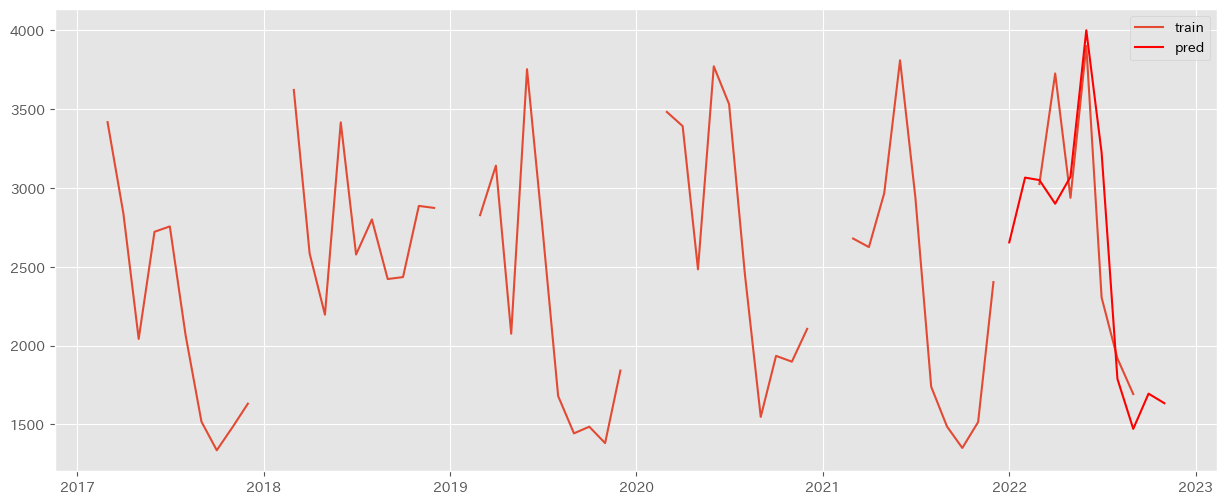

In [63]:
# 予測
pred = SARIMA_3_2_2_110.predict('2022-01-01', '2022-11-01')
# 実データと予測結果の図示
plt.plot(train_data[kind], label="train")
plt.plot(pred, "r", label="pred")
plt.legend()